In [ ]:
# Instalar librerias necesarias
#!pip install dash plotly dash_bootstrap_components

In [131]:
# Librerias
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dash
from dash import dcc
from dash import html
import pandas as pd
import plotly.express as px
import plotly.express as px
import geopandas as gpd

In [117]:
# Lectura de la base de datos
archivo_pickle = '/content/Entrenamiento_cronicas_N.pkl'
with open(archivo_pickle, 'rb') as file:
    data_ori = pickle.load(file)

In [132]:
data= data_ori.copy()

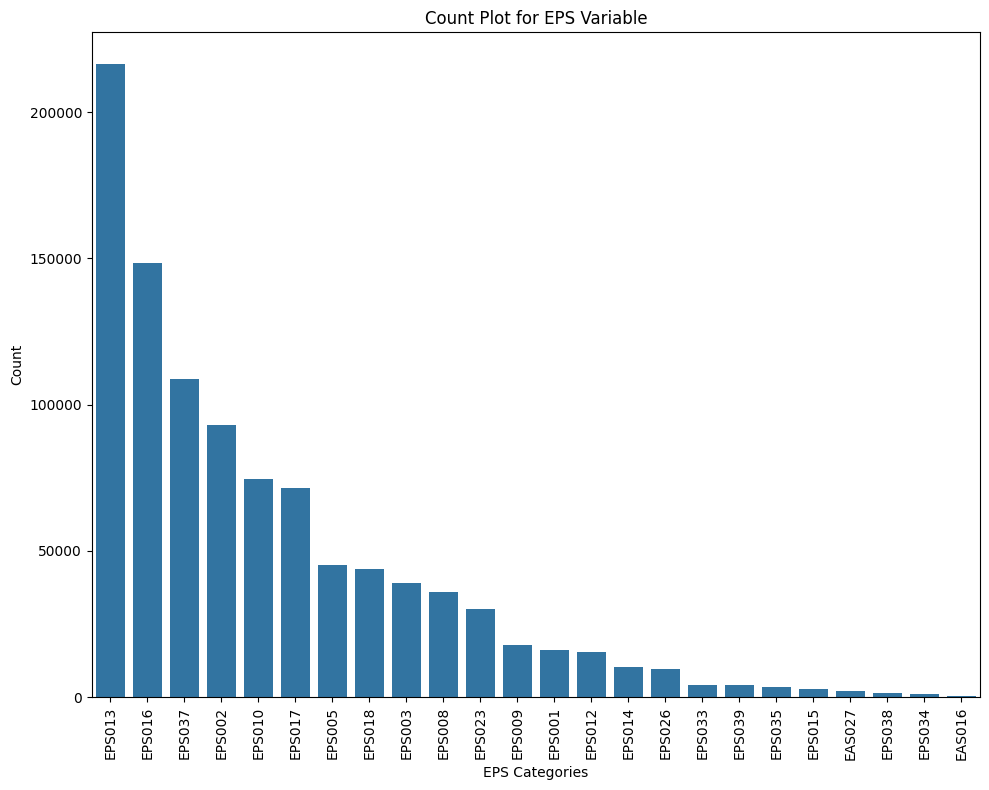

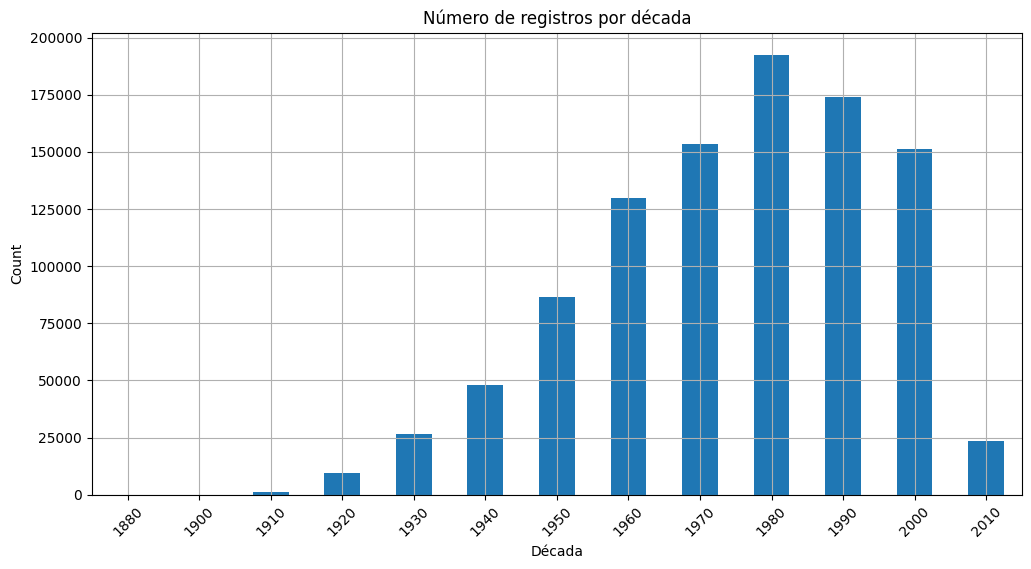

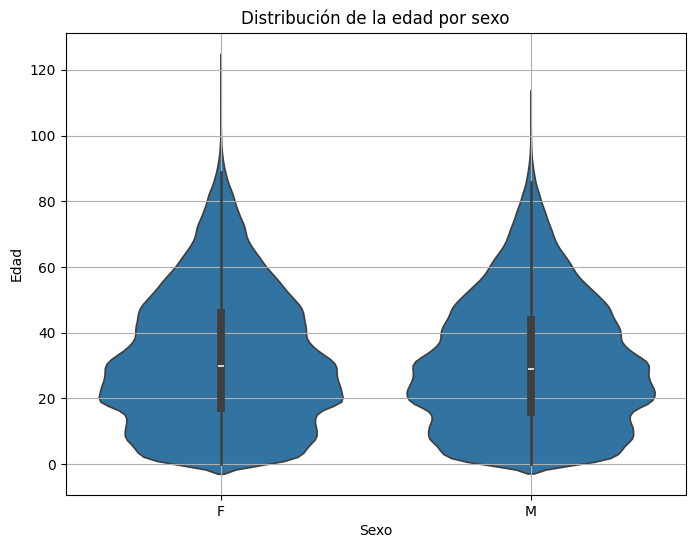

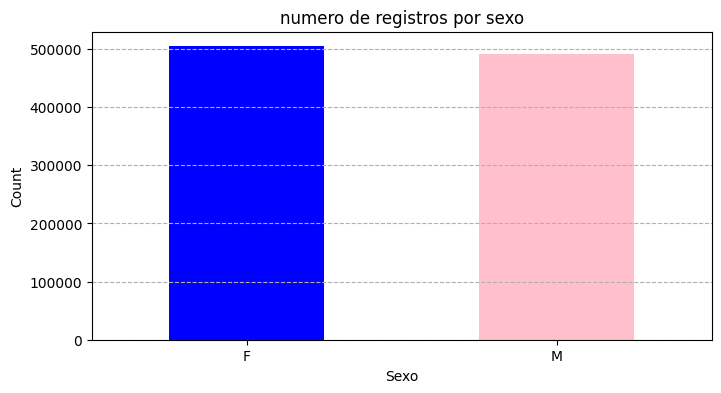

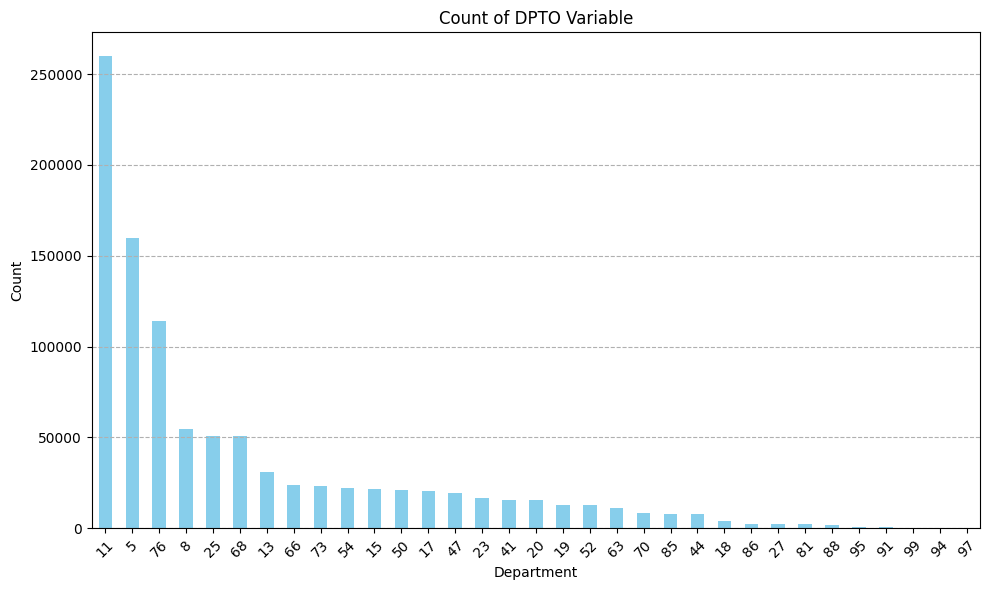

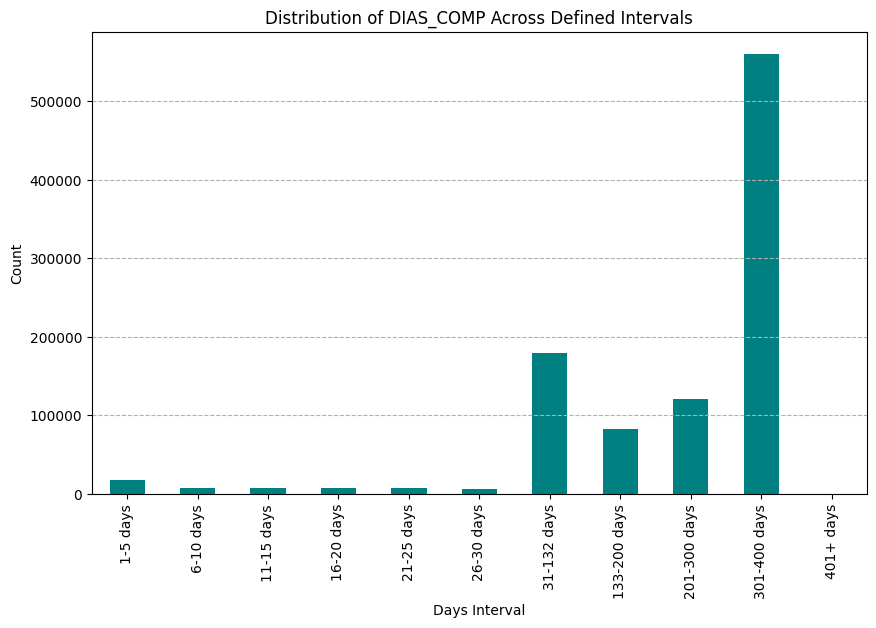

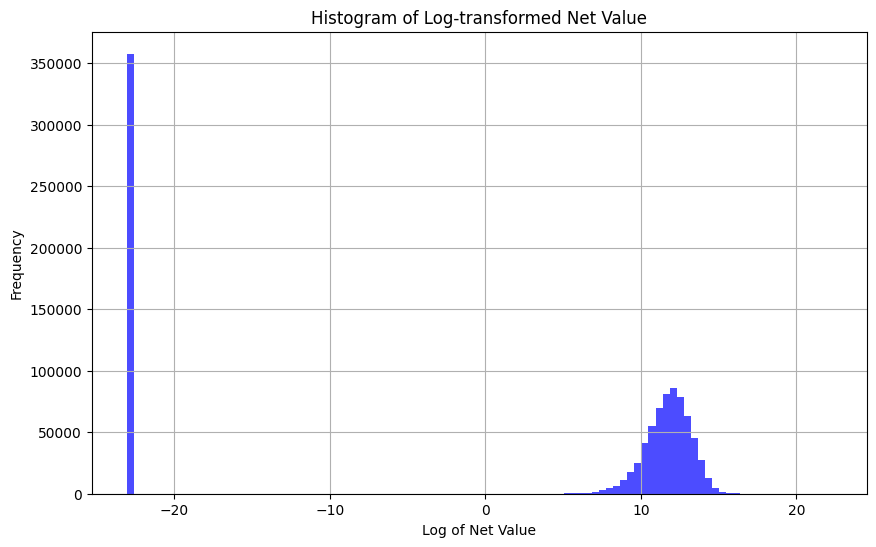

In [133]:
data['FECHA_NACI'] = pd.to_datetime(data['FECHA_NACI'])
data = data.drop(columns=['Valor_Neto_Chunk','DIAS_ESTAN_Neto_Chunk'])
plt.figure(figsize=(10, 8))
sns.countplot(x='EPS', data=data, order=data['EPS'].value_counts().index)
plt.title('Count Plot for EPS Variable')
plt.xlabel('EPS Categories')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotates the labels on the x-axis for better readability
plt.tight_layout()
plt.show()
# Create a new column for the decade
data['Decade'] = (data['FECHA_NACI'].dt.year // 10) * 10

# Count the number of entries per decade
decade_counts = data['Decade'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
decade_counts.plot(kind='bar')
plt.title('Número de registros por década')
plt.xlabel('Década')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Assuming data['Age'] exists and is a numerical column
plt.figure(figsize=(8, 6))
sns.violinplot(x='SEXO', y='Edad', data=data)
plt.title('Distribución de la edad por sexo')
plt.xlabel('Sexo')
plt.ylabel('Edad')
plt.grid(True)
plt.show()

sexo_counts = data['SEXO'].value_counts()

# Plotting
plt.figure(figsize=(8, 4))
sexo_counts.plot(kind='bar', color=['blue', 'pink'])  # Adjust colors if necessary
plt.title('numero de registros por sexo')
plt.xlabel('Sexo')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keeps the labels horizontal
plt.grid(axis='y', linestyle='--')  # Adds horizontal grid lines
plt.show()
dpto_counts = data['DPTO'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
dpto_counts.plot(kind='bar', color='skyblue')
plt.title('Count of DPTO Variable')
plt.xlabel('Department')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()
# Assuming the data DataFrame and the 'DIAS_COMP' column already exist and are numeric
# Convert the 'DIAS_COMP' column to numeric just in case and handle any potential conversion errors
data['DIAS_COMP'] = pd.to_numeric(data['DIAS_COMP'], errors='coerce')

# Define more detailed bins for the histogram
bins = [0, 5, 10, 15, 20, 25, 30, 132, 200, 300, 400, data['DIAS_COMP'].max() + 1]
labels = ['1-5 days', '6-10 days', '11-15 days', '16-20 days', '21-25 days', '26-30 days', '31-132 days',
          '133-200 days', '201-300 days', '301-400 days', '401+ days']

# Categorize 'DIAS_COMP' into bins
data['DIAS_COMP_Binned'] = pd.cut(data['DIAS_COMP'], bins=bins, labels=labels, right=False)

# Count the number of occurrences in each bin
binned_counts = data['DIAS_COMP_Binned'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
binned_counts.plot(kind='bar', color='teal')
plt.title('Distribution of DIAS_COMP Across Defined Intervals')
plt.xlabel('Days Interval')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--')
plt.show()


data['Valor_Neto_Log'] = np.log(data['Valor_Neto'] + 1e-10)
plt.figure(figsize=(10, 6))
plt.hist(data['Valor_Neto_Log'], bins=100, color='blue', alpha=0.7)
plt.title('Histogram of Log-transformed Net Value')
plt.xlabel('Log of Net Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import panel as pn

# Extender panel para usar Plotly
pn.extension('plotly')

# Agrupar los datos por departamento y calcular la media
costos_por_departamento = data.groupby('DPTO')['Valor_Neto'].mean().reset_index()
costos_por_departamento_sin_gasto = data[data['Valor_Neto']==0].groupby('DPTO')['Valor_Neto'].mean().reset_index()
costos_por_departamento_con_gasto  = data[data['Valor_Neto']>0].groupby('DPTO')['Valor_Neto'].mean().reset_index()

# Cargar el archivo GeoJSON
gdf = gpd.read_file("/content/colombia.geo.json")

# Asegurarse de que las columnas DPTO sean del mismo tipo
gdf['DPTO'] = gdf['DPTO'].astype(int)
costos_por_departamento['DPTO'] = costos_por_departamento['DPTO'].astype(int)
costos_por_departamento_sin_gasto['DPTO'] = costos_por_departamento_sin_gasto ['DPTO'].astype(int)
costos_por_departamento_con_gasto ['DPTO'] = costos_por_departamento_con_gasto ['DPTO'].astype(int)

# Unir el GeoDataFrame con el DataFrame de datos
gdf = gdf.merge(costos_por_departamento, on="DPTO")

# Función para crear la figura del mapa
def create_figure(filtered_gdf):
    fig = px.choropleth(
        filtered_gdf,
        geojson=filtered_gdf.set_geometry('geometry').__geo_interface__,
        locations=filtered_gdf.index,
        color="Valor_Neto",
        projection="mercator",
        hover_name="NOMBRE_DPT"
    ).update_geos(
        fitbounds="locations",
        visible=False
    ).update_layout(
        title="Mapa de Calor de Colombia por Departamentos",
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )
    return fig

# Función para actualizar el mapa
def update_map(event):
    filtro = event.new
    if filtro == "Con Gasto":
        filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento_con_gasto, on="DPTO")
    elif filtro == "Sin Gasto":
      filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento_sin_gasto, on="DPTO")
    else:
      filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento, on="DPTO")

    map_pane.object = create_figure(filtered_gdf)

# Crear los botones y el gráfico inicial
buttons = pn.widgets.RadioButtonGroup(
    name='Filtro',
    options=['Toda la Data', 'Con Gasto', 'Sin Gasto'],
    button_type='success'
)

# Inicializar el gráfico
initial_figure = create_figure(gdf)
map_pane = pn.pane.Plotly(initial_figure, height=600)

# Vincular la función de actualización al cambio de valor de los botones
buttons.param.watch(update_map, 'value')

# Layout del Panel
dashboard = pn.Column(
    "# Dashboard EDA y Mapa de Colombia",
    buttons,
    map_pane
)

# Servir la aplicación
dashboard.servable()

Column
    [0] Markdown(str)
    [1] RadioButtonGroup(button_type='success', name='Filtro', options=['Toda la Data', ...], value='Toda la Data')
    [2] Plotly(Figure, height=600)

# DASH

In [135]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import pandas as pd
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
#Definir Texto Intro

intro_text = """
Bienvenido al Dashboard EDA y Modelos

Este es un dashboard interactivo creado con Plotly Dash. Aquí puedes explorar datos y ejecutar modelos.

Selecciona una base de datos y explora el análisis exploratorio de datos (EDA) o ejecuta un modelo.
"""

# Agrupar los datos por departamento y calcular la media
costos_por_departamento = data.groupby('DPTO')['Valor_Neto'].mean().reset_index()
costos_por_departamento_sin_gasto = data[data['Valor_Neto']==0].groupby('DPTO')['Valor_Neto'].mean().reset_index()
costos_por_departamento_con_gasto  = data[data['Valor_Neto']>0].groupby('DPTO')['Valor_Neto'].mean().reset_index()

# Cargar el archivo GeoJSON
gdf = gpd.read_file("/content/colombia.geo.json")

# Asegurarse de que las columnas DPTO sean del mismo tipo
gdf['DPTO'] = gdf['DPTO'].astype(int)
costos_por_departamento['DPTO'] = costos_por_departamento['DPTO'].astype(int)
costos_por_departamento_sin_gasto['DPTO'] = costos_por_departamento_sin_gasto ['DPTO'].astype(int)
costos_por_departamento_con_gasto ['DPTO'] = costos_por_departamento_con_gasto ['DPTO'].astype(int)

gdf_ini = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento, on="DPTO")

# Crear la aplicación Dash
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP],
                meta_tags=[{"name": "viewport", "content": "width=device-width, initial-scale=1.0"}],  # Etiquetas meta para responsividad
                suppress_callback_exceptions=True,  # Suprimir excepciones de callback
                title='Privacidad Diferencial de Datos',  # Título de la página
                update_title='Cargando...',  # Título temporal durante la actualización de callbacks
                serve_locally=True,  # Servir archivos locales
)
app.config.suppress_callback_exceptions = True
# Crear el gráfico inicial sin filtros
fig_initial = px.choropleth(
    gdf_ini,
    geojson=gdf_ini.set_geometry('geometry').__geo_interface__,
    locations=gdf_ini.index,
    color="Valor_Neto",
    projection="mercator",
    hover_name="NOMBRE_DPT"
).update_geos(
    fitbounds="locations",
    visible=False
).update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

# Definir el layout de la aplicación
app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    dbc.NavbarSimple(
        children=[
            dbc.NavItem(dbc.NavLink("Introducción", href="/")),
            dbc.NavItem(dbc.NavLink("Análisis Descriptivo Exploratorio", href="/eda")),
            dbc.NavItem(dbc.NavLink("Modelos", href="/modelos")),
            dbc.NavItem(dbc.NavLink("Conclusiones", href="/conclusiones")),
        ],
        brand="Privacidad Diferencial de Datos",
        color="primary",
        dark=True,
    ),
    html.Div(id='page-content')
])

# Componente común del pie de página
footer = html.Div([
    html.Img(src='https://upload.wikimedia.org/wikipedia/commons/c/c9/Universidad_de_los_Andes_%28logo%29.png', style={'display': 'block', 'margin': 'auto', 'width': '100px'}),
    html.P(['Maestría en Inteligencia Análitica para la',
        html.Br(),
        'Toma de Decisiones',
        html.Br(),
        'Autores:'
    ], style={'textAlign': 'center', 'marginTop': 10}),
    html.Ul([
        html.Li('Luisa De La Hortúa'),
        html.Li('David Romero'),
        html.Li('David Moreno'),
        html.Li('Allan Ramírez')
    ], style={'textAlign': 'center', 'listStylePosition': 'inside'})
], style={'marginTop': 50})

# Página de Introducción
intro_layout = html.Div([
    html.H1('Introducción'),
    html.Hr(),
    html.P(intro_text),
    dash_table.DataTable(data=data_ori.head(5).to_dict('records'), page_size=6),
    html.Br(),
    html.P('Continuación de la intro.'),
    footer  # Añadir el pie de página
])

# Página de Análisis Descriptivo Exploratorio
eda_layout = html.Div([
    html.H1('Análisis Descriptivo Exploratorio'),
    html.Hr(),
    html.H2('Mapa de Calor de Colombia por Departamentos'),
    dbc.ButtonGroup(
        [
            dbc.Button("Con Gasto", id="btn-con-gasto", color="primary", className="mr-1"),
            dbc.Button("Sin Gasto", id="btn-sin-gasto", color="primary", className="mr-1"),
            dbc.Button("Toda la Data", id="btn-toda-data", color="primary", className="mr-1", active=True)
        ],
        className="mr-3",
    ),
    dcc.Graph(id='colombia-map', figure=fig_initial),
    footer  # Añadir el pie de página
])

# Página de Modelos
modelos_layout = html.Div([
    html.H1('Modelos'),
    html.Hr(),
    html.P('Esta es la página de modelos.'),
    footer  # Añadir el pie de página
])

# Página de Conclusiones
conclusiones_layout = html.Div([
    html.H1('Conclusiones'),
    html.Hr(),
    html.P('Esta es la página de conclusiones.'),
    footer  # Añadir el pie de página
])
# Callback para actualizar el contenido de la página
@app.callback(Output('page-content', 'children'),
              [Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/eda':
        return eda_layout
    elif pathname == '/modelos':
        return modelos_layout
    elif pathname == '/conclusiones':
        return conclusiones_layout
    else:
        return intro_layout

# Callback para actualizar el gráfico basado en el botón seleccionado
@app.callback(
    Output('colombia-map', 'figure'),
    [Input('btn-con-gasto', 'n_clicks'),
     Input('btn-sin-gasto', 'n_clicks'),
     Input('btn-toda-data', 'n_clicks')]
)
def update_map(con_gasto_clicks, sin_gasto_clicks, toda_data_clicks):
    ctx = dash.callback_context

    if not ctx.triggered:
        # Mostrar toda la data por defecto
        filtered_data = data
    else:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]

        if button_id == "btn-con-gasto":
            filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento_con_gasto, on="DPTO")
        elif button_id == "btn-sin-gasto":
            filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento_sin_gasto, on="DPTO")
        else:
            filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento, on="DPTO")

    fig = px.choropleth(
        filtered_gdf,
        geojson=filtered_gdf.set_geometry('geometry').__geo_interface__,
        locations=filtered_gdf.index,
        color="Valor_Neto",
        projection="mercator",
        hover_name="NOMBRE_DPT"
    ).update_geos(
        fitbounds="locations",
        visible=False
    ).update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    return fig

def update_map(con_gasto_clicks, sin_gasto_clicks, toda_data_clicks):
    ctx = dash.callback_context

    if not ctx.triggered:
        # Mostrar toda la data por defecto
        filtered_data = data
    else:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]

        if button_id == "btn-con-gasto":
            filtered_data = data_gasto
        elif button_id == "btn-sin-gasto":
            filtered_data = data_sin_gasto
        else:
            filtered_data = data

    fig = px.choropleth(
        filtered_gdf,
        geojson=filtered_gdf.set_geometry('geometry').__geo_interface__,
        locations=filtered_gdf.index,
        color="Valor_Neto",
        projection="mercator",
        hover_name="NOMBRE_DPT"
    ).update_geos(
        fitbounds="locations",
        visible=False
    ).update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    return fig


#app.run(debug=True)
app.run(jupyter_mode="external")

Dash app running on:


<IPython.core.display.Javascript object>

In [138]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import pandas as pd
import geopandas as gpd
import plotly.express as px
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

# Definir Texto Intro
intro_text = """
Bienvenido al Dashboard EDA y Modelos

Este es un dashboard interactivo creado con Plotly Dash. Aquí puedes explorar datos y ejecutar modelos.

Selecciona una base de datos y explora el análisis exploratorio de datos (EDA) o ejecuta un modelo.
"""

# Crear un DataFrame de ejemplo con datos

# Agrupar los datos por departamento y calcular la media
costos_por_departamento = data.groupby('DPTO')['Valor_Neto'].mean().reset_index()
costos_por_departamento_sin_gasto = data[data['Valor_Neto'] == 0].groupby('DPTO')['Valor_Neto'].mean().reset_index()
costos_por_departamento_con_gasto = data[data['Valor_Neto'] > 0].groupby('DPTO')['Valor_Neto'].mean().reset_index()

# Cargar el archivo GeoJSON
gdf = gpd.read_file("colombia.geo.json")

# Asegurarse de que las columnas DPTO sean del mismo tipo
gdf['DPTO'] = gdf['DPTO'].astype(int)
costos_por_departamento['DPTO'] = costos_por_departamento['DPTO'].astype(int)
costos_por_departamento_sin_gasto['DPTO'] = costos_por_departamento_sin_gasto['DPTO'].astype(int)
costos_por_departamento_con_gasto['DPTO'] = costos_por_departamento_con_gasto['DPTO'].astype(int)

gdf_ini = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento, on="DPTO")

# Crear la aplicación Dash
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP],
                meta_tags=[{"name": "viewport", "content": "width=device-width, initial-scale=1.0"}],  # Etiquetas meta para responsividad
                suppress_callback_exceptions=True,  # Suprimir excepciones de callback
                title='Privacidad Diferencial de Datos',  # Título de la página
                update_title='Cargando...',  # Título temporal durante la actualización de callbacks
                serve_locally=True,  # Servir archivos locales
)
app.config.suppress_callback_exceptions = True

# Crear el gráfico inicial sin filtros
fig_initial_map = px.choropleth(
    gdf_ini,
    geojson=gdf_ini.set_geometry('geometry').__geo_interface__,
    locations=gdf_ini.index,
    color="Valor_Neto",
    projection="mercator",
    hover_name="NOMBRE_DPT"
).update_geos(
    fitbounds="locations",
    visible=False
).update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

# Crear el gráfico inicial de violín
fig_initial_violin = px.violin(data, x="SEXO", y="Edad", color="SEXO", box=True, points="all")
fig_initial_violin.update_layout(title="Distribución de Edad y Sexo")

# Definir el layout de la aplicación
app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    dbc.NavbarSimple(
        children=[
            dbc.NavItem(dbc.NavLink("Introducción", href="/")),
            dbc.NavItem(dbc.NavLink("Análisis Descriptivo Exploratorio", href="/eda")),
            dbc.NavItem(dbc.NavLink("Modelos", href="/modelos")),
            dbc.NavItem(dbc.NavLink("Conclusiones", href="/conclusiones")),
        ],
        brand="Privacidad Diferencial de Datos",
        color="primary",
        dark=True,
    ),
    html.Div(id='page-content')
])

# Componente común del pie de página
footer = html.Div([
    html.Img(src='https://upload.wikimedia.org/wikipedia/commons/c/c9/Universidad_de_los_Andes_%28logo%29.png', style={'display': 'block', 'margin': 'auto', 'width': '100px'}),
    html.P(['Maestría en Inteligencia Análitica para la',
        html.Br(),
        'Toma de Decisiones',
        html.Br(),
        'Autores:'
    ], style={'textAlign': 'center', 'marginTop': 10}),
    html.Ul([
        html.Li('Luisa De La Hortúa'),
        html.Li('David Romero'),
        html.Li('David Moreno'),
        html.Li('Allan Ramírez')
    ], style={'textAlign': 'center', 'listStylePosition': 'inside'})
], style={'marginTop': 50})

# Página de Introducción
intro_layout = html.Div([
    html.H1('Introducción'),
    html.Hr(),
    html.P(intro_text),
    dash_table.DataTable(data=data.head(5).to_dict('records'), page_size=6),
    html.Br(),
    html.P('Continuación de la intro.'),
    footer  # Añadir el pie de página
])

# Página de Análisis Descriptivo Exploratorio
eda_layout = html.Div([
    html.H1('Análisis Descriptivo Exploratorio'),
    html.Hr(),
    html.H2('Mapa de Calor de Colombia por Departamentos'),
    dbc.ButtonGroup(
        [
            dbc.Button("Con Gasto", id="btn-con-gasto", color="primary", className="mr-1"),
            dbc.Button("Sin Gasto", id="btn-sin-gasto", color="primary", className="mr-1"),
            dbc.Button("Toda la Data", id="btn-toda-data", color="primary", className="mr-1", active=True)
        ],
        className="mr-3",
    ),
    dcc.Graph(id='colombia-map', figure=fig_initial_map),
    html.H2('Distribución de Edad y Sexo'),
    dcc.Graph(id='violin-plot', figure=fig_initial_violin),
    footer  # Añadir el pie de página
])

# Página de Modelos
modelos_layout = html.Div([
    html.H1('Modelos'),
    html.Hr(),
    html.P('Esta es la página de modelos.'),
    footer  # Añadir el pie de página
])

# Página de Conclusiones
conclusiones_layout = html.Div([
    html.H1('Conclusiones'),
    html.Hr(),
    html.P('Esta es la página de conclusiones.'),
    footer  # Añadir el pie de página
])

# Callback para actualizar el contenido de la página
@app.callback(Output('page-content', 'children'),
              [Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/eda':
        return eda_layout
    elif pathname == '/modelos':
        return modelos_layout
    elif pathname == '/conclusiones':
        return conclusiones_layout
    else:
        return intro_layout

# Callback para actualizar los gráficos basado en el botón seleccionado
@app.callback(
    [Output('colombia-map', 'figure'),
     Output('violin-plot', 'figure')],
    [Input('btn-con-gasto', 'n_clicks'),
     Input('btn-sin-gasto', 'n_clicks'),
     Input('btn-toda-data', 'n_clicks')]
)
def update_graphs(con_gasto_clicks, sin_gasto_clicks, toda_data_clicks):
    ctx = dash.callback_context

    if not ctx.triggered:
        # Mostrar toda la data por defecto
        filtered_data = data
        filtered_gdf = gdf_ini
    else:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]

        if button_id == "btn-con-gasto":
            filtered_data = data[data['Valor_Neto'] > 0]
            filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento_con_gasto, on="DPTO")
        elif button_id == "btn-sin-gasto":
            filtered_data = data[data['Valor_Neto'] == 0]
            filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento_sin_gasto, on="DPTO")
        else:
            filtered_data = data
            filtered_gdf = gdf_ini

    fig_map = px.choropleth(
        filtered_gdf,
        geojson=filtered_gdf.set_geometry('geometry').__geo_interface__,
        locations=filtered_gdf.index,
        color="Valor_Neto",
        projection="mercator",
        hover_name="NOMBRE_DPT"
    ).update_geos(
        fitbounds="locations",
        visible=False
    ).update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    fig_violin = px.violin(filtered_data, x="SEXO", y="Edad", color="SEXO", box=True, points="all")
    fig_violin.update_layout(title="Distribución de Edad y Sexo")

    return fig_map, fig_violin

# Ejecutar la aplicación
app.run(jupyter_mode="external")

Dash app running on:


<IPython.core.display.Javascript object>

Column
    [0] Markdown(str)
    [1] RadioButtonGroup(button_type='success', name='Filtro de Datos', options=['Toda la Data', ...], value='Toda la Data')
    [2] ParamFunction(function, _pane=Column, defer_load=False)
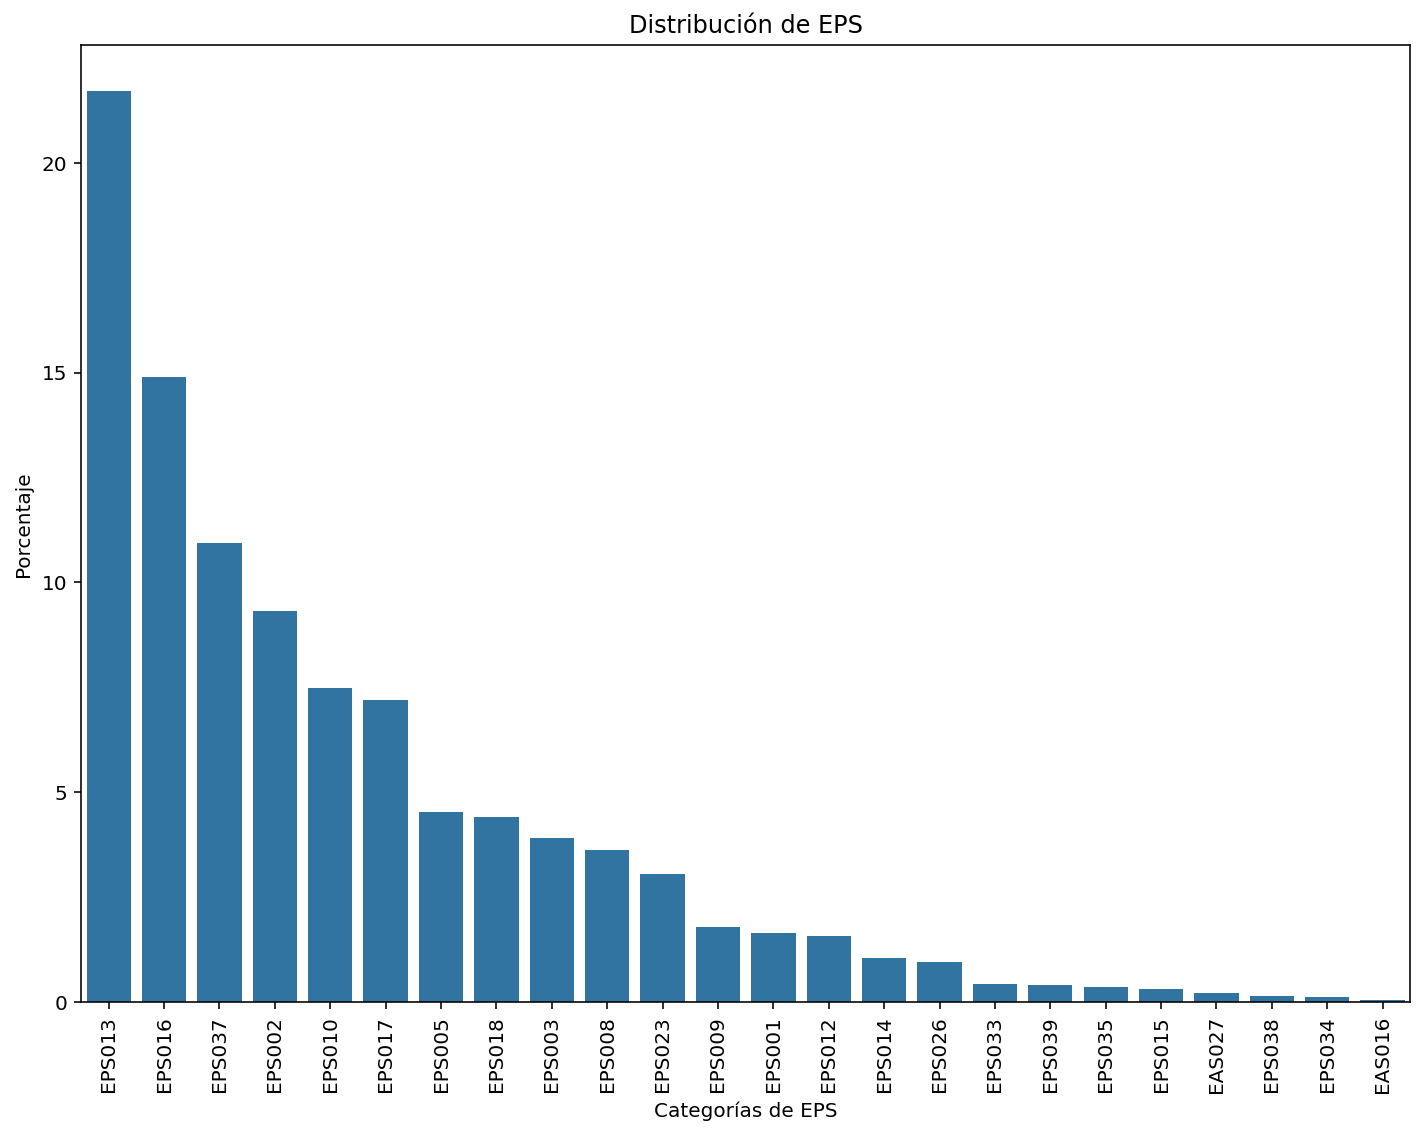
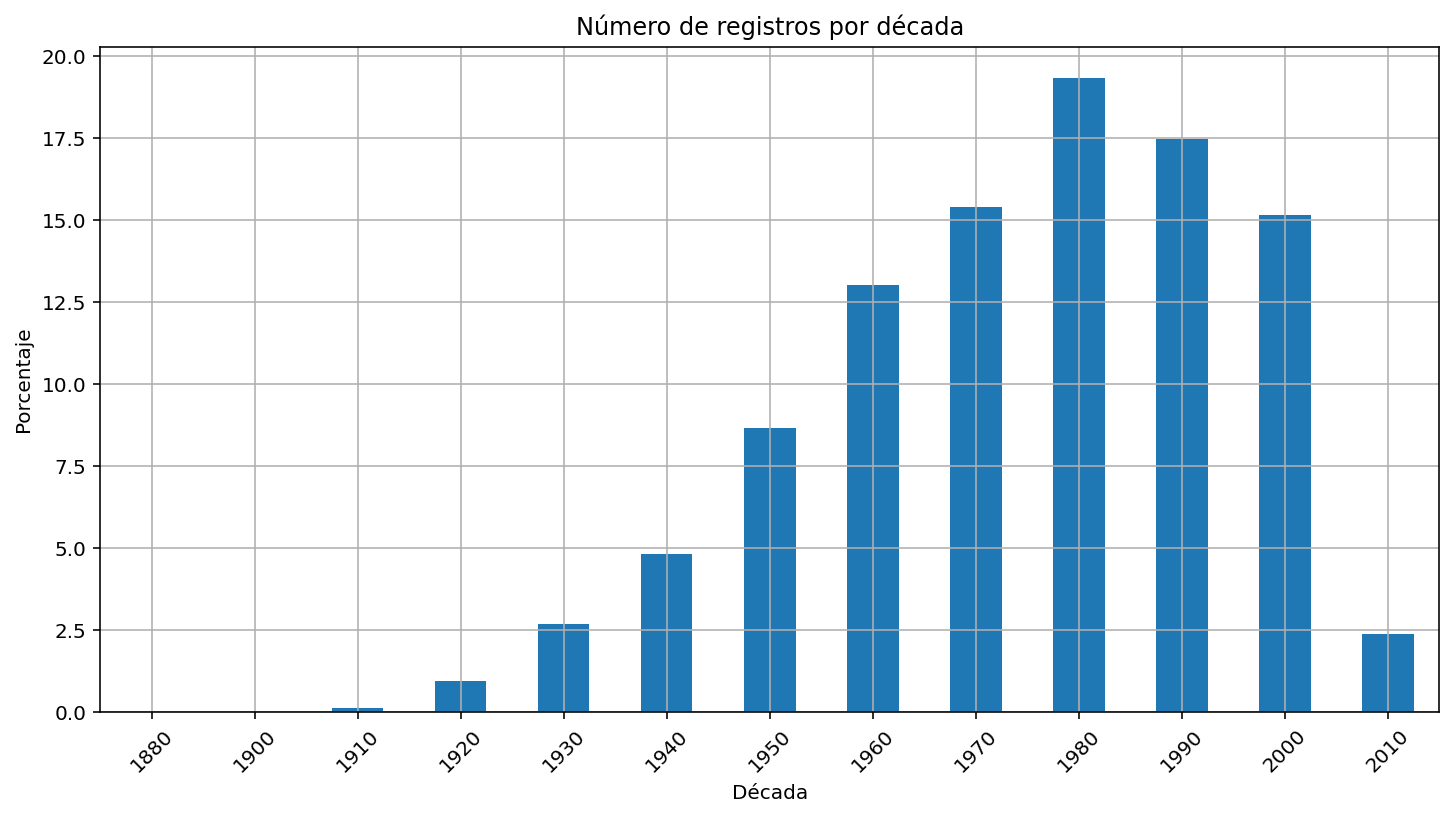
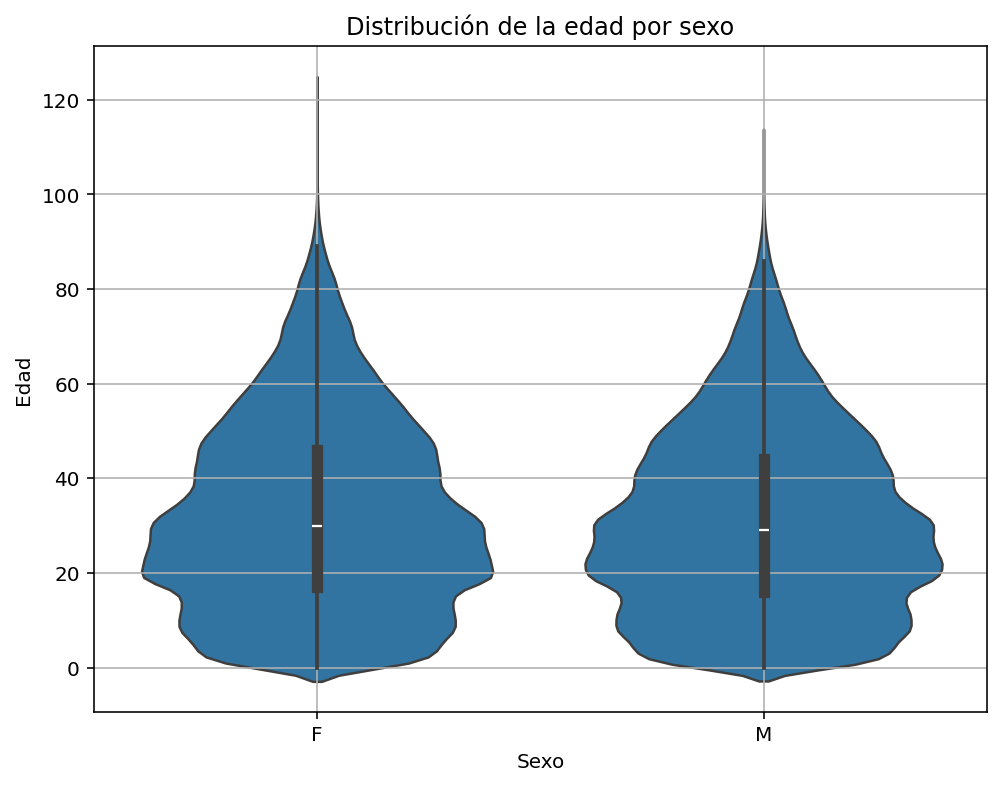
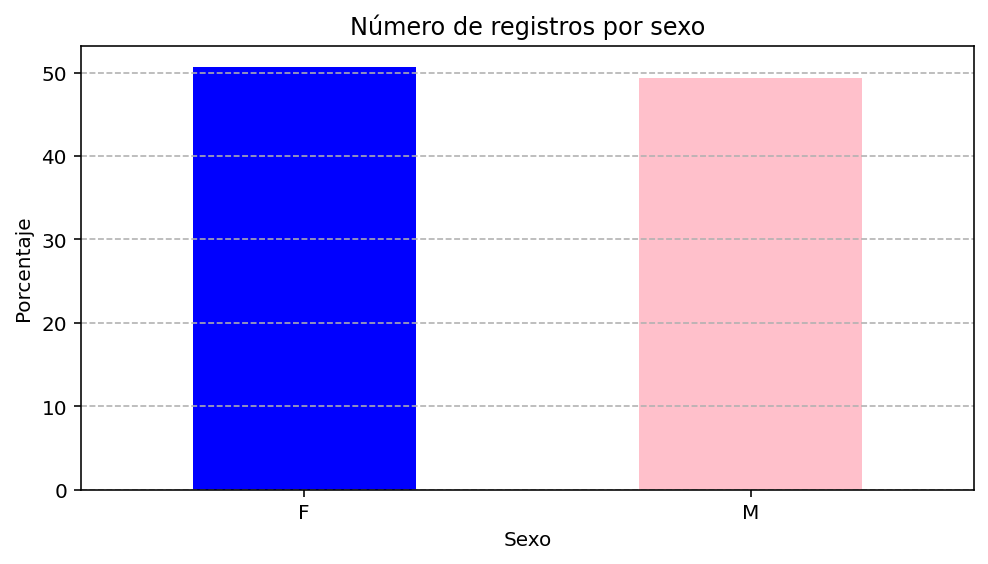
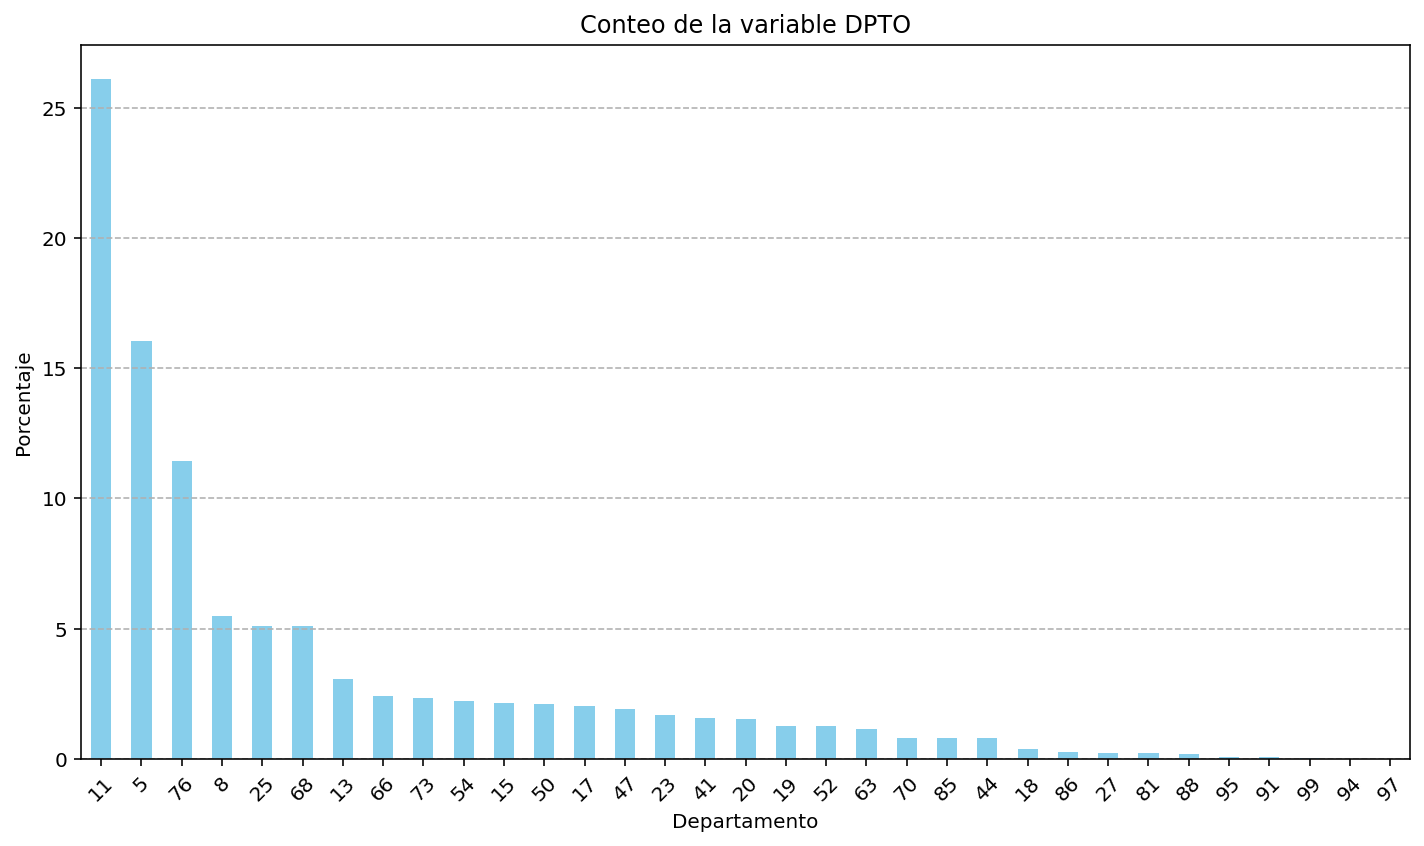
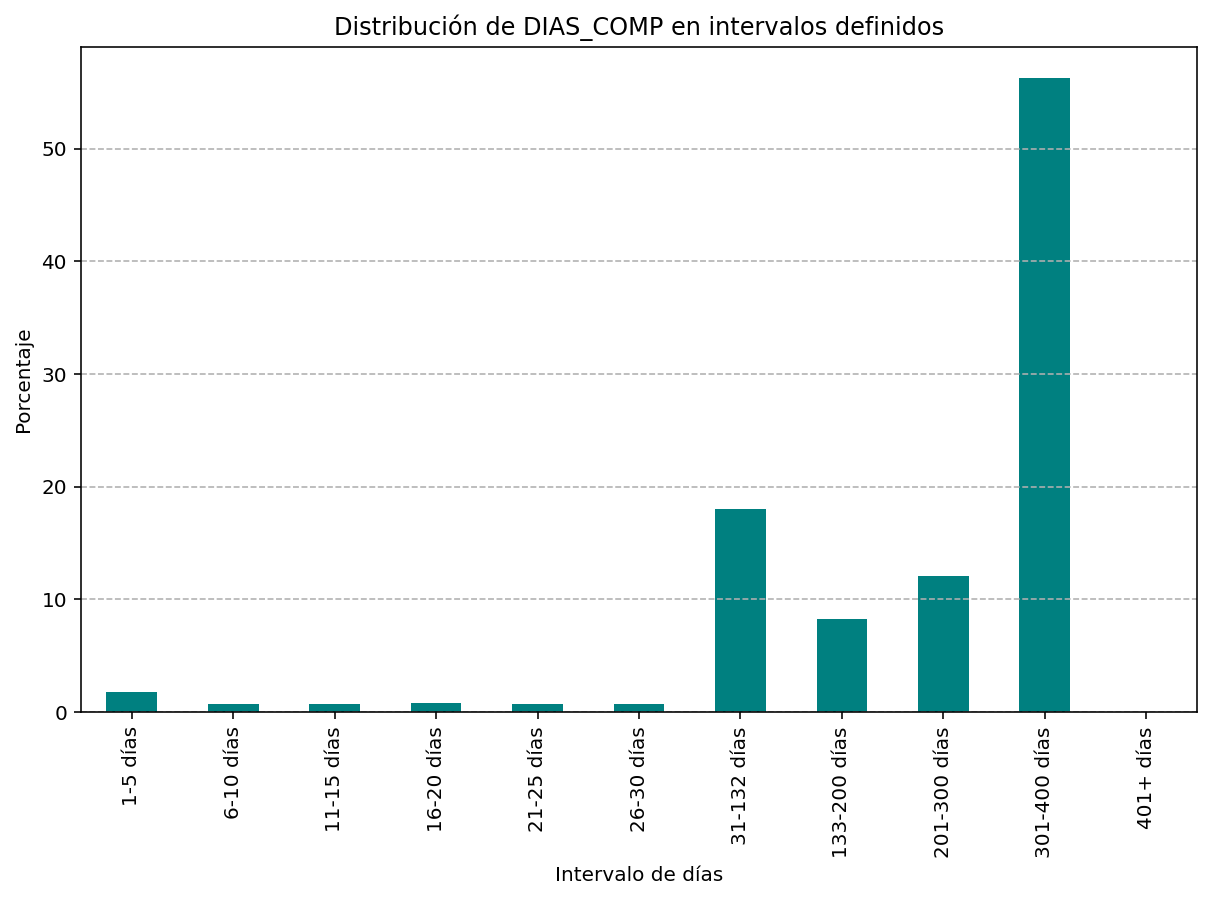
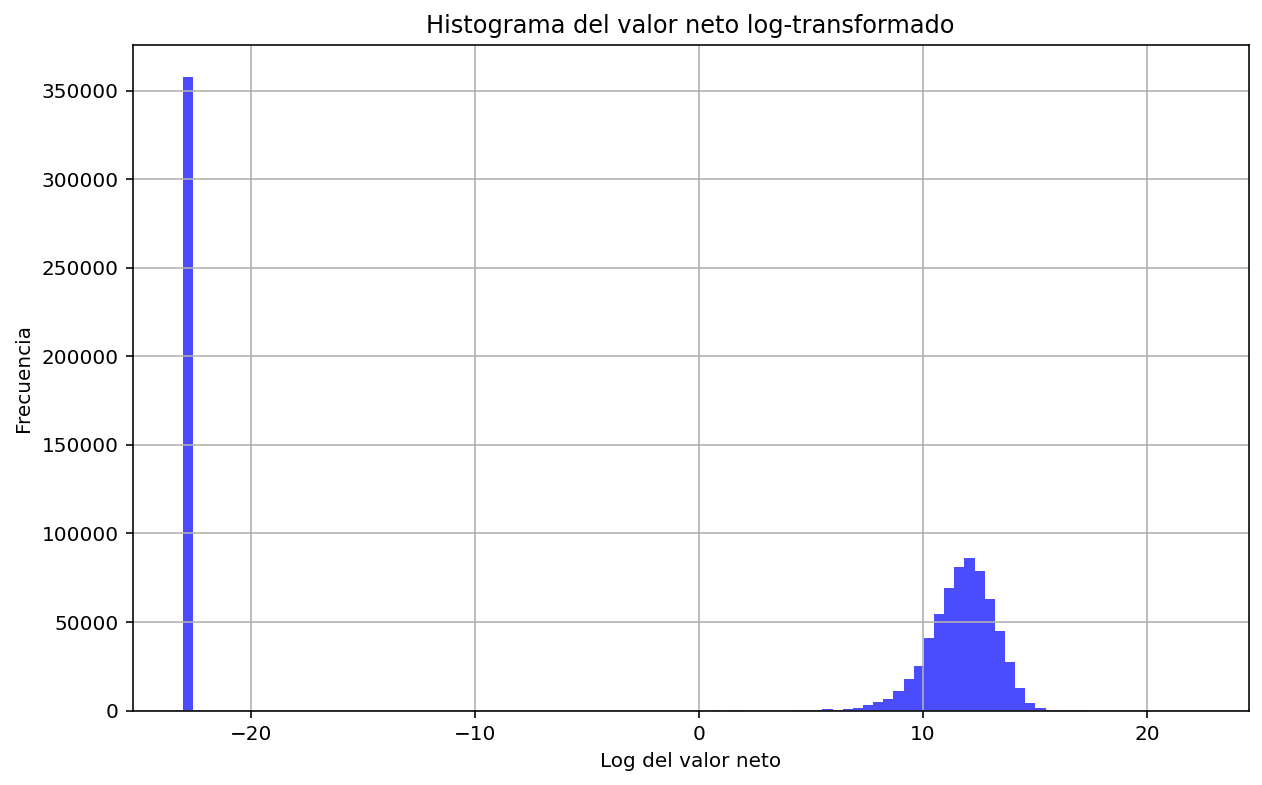

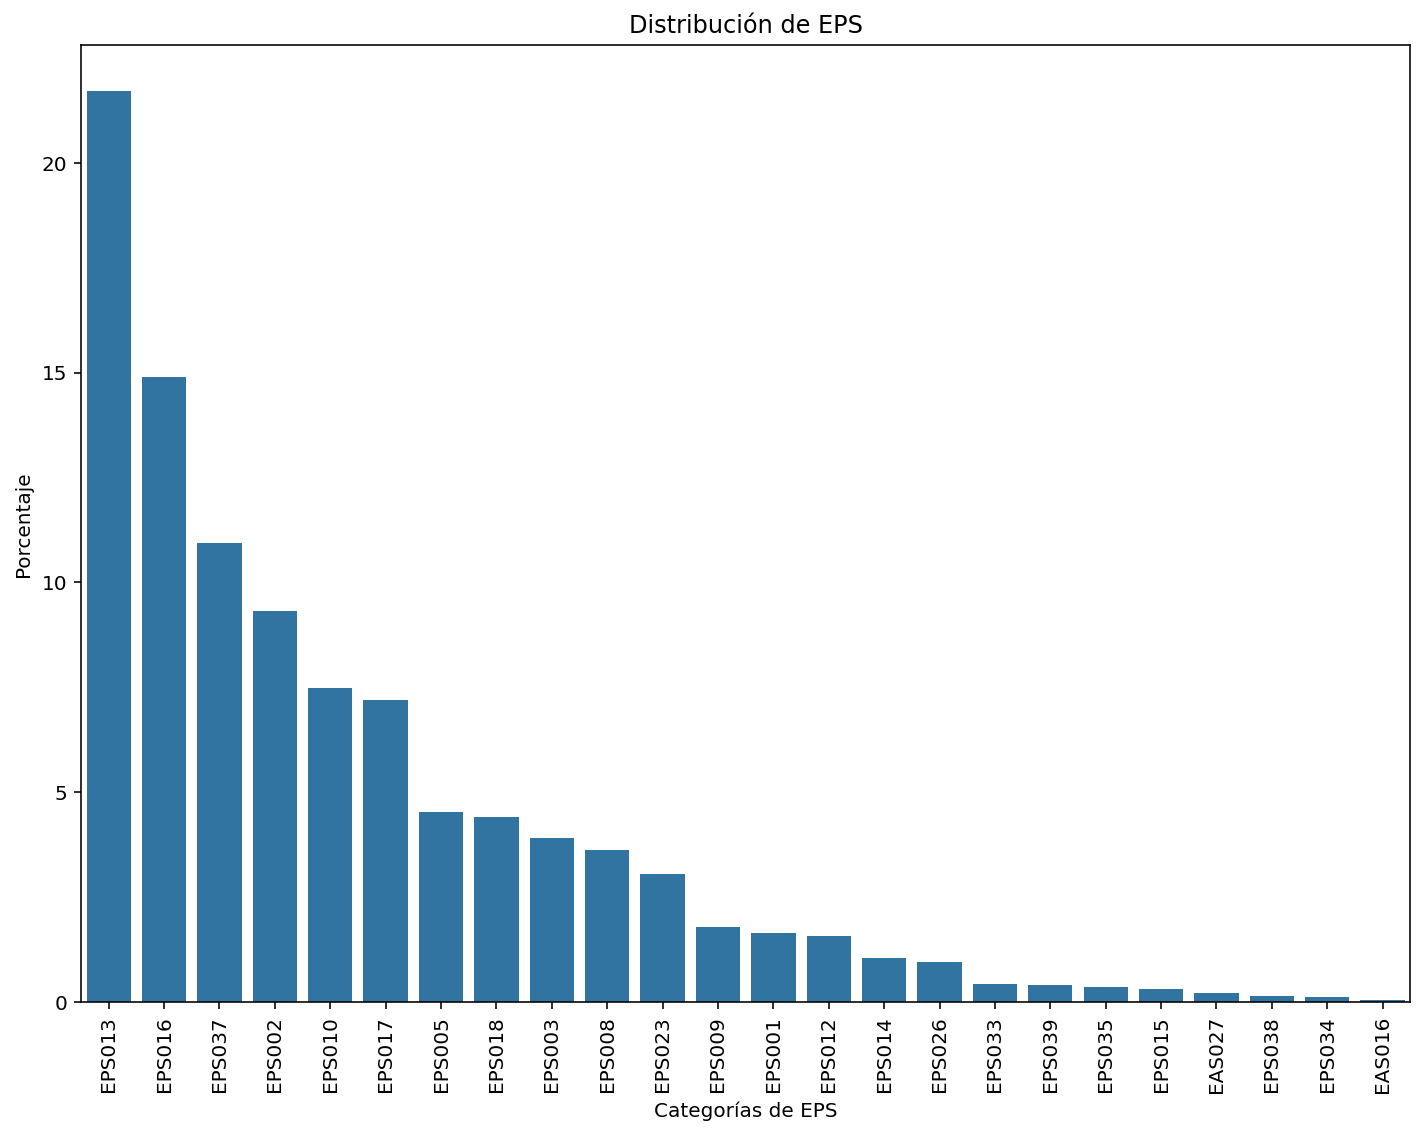

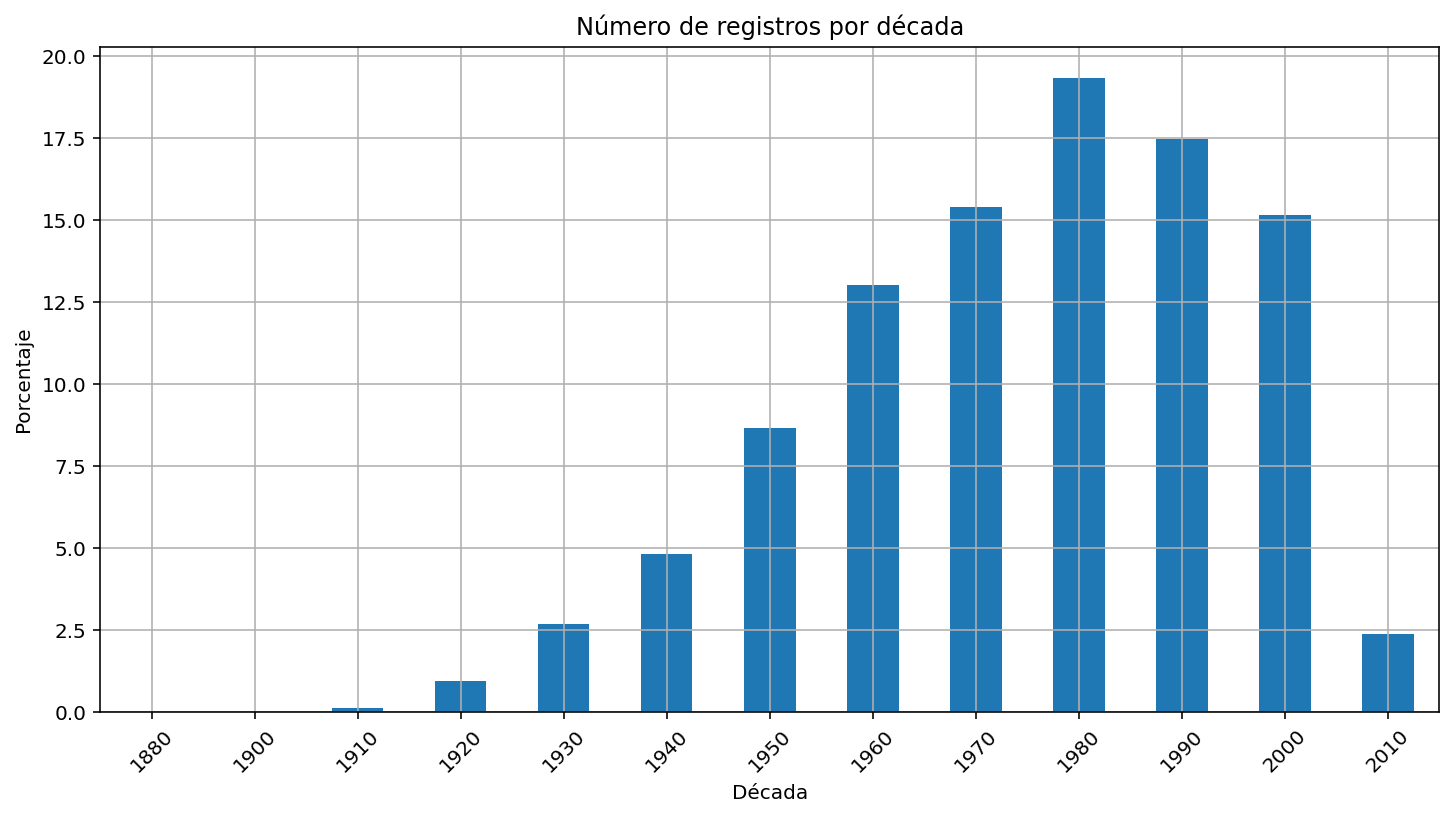

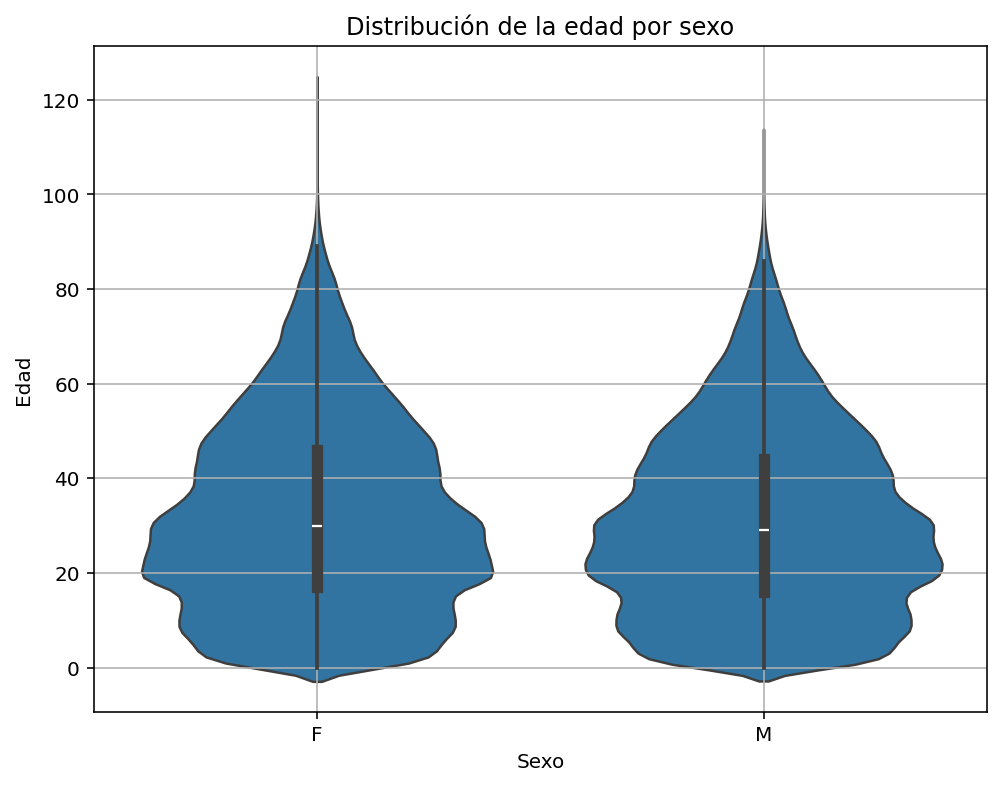

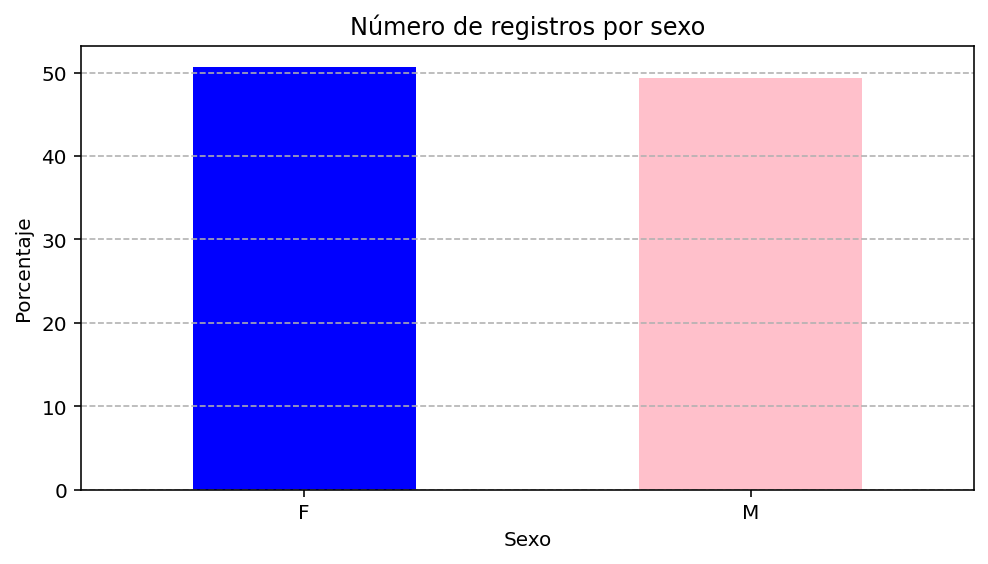

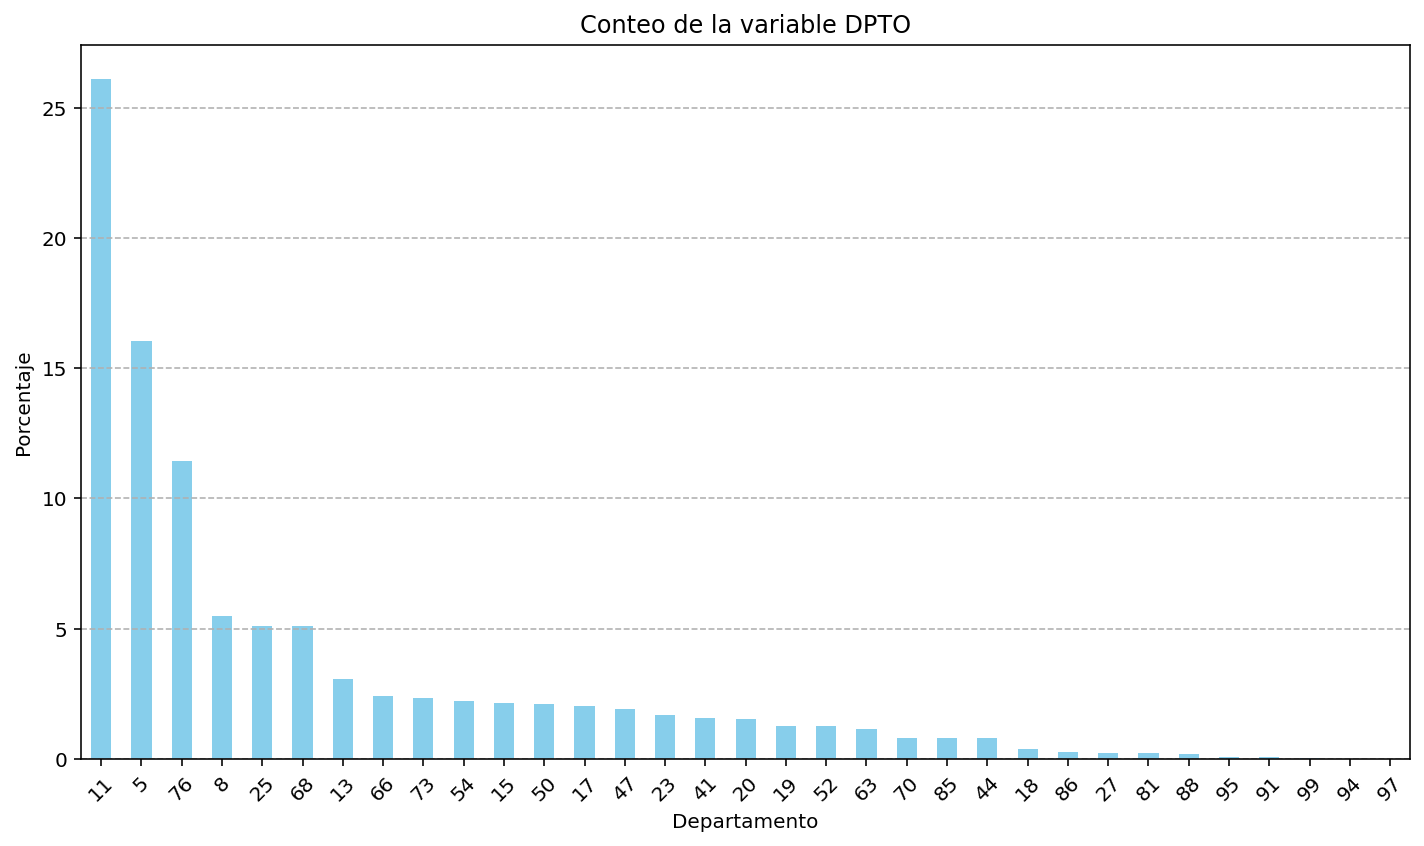

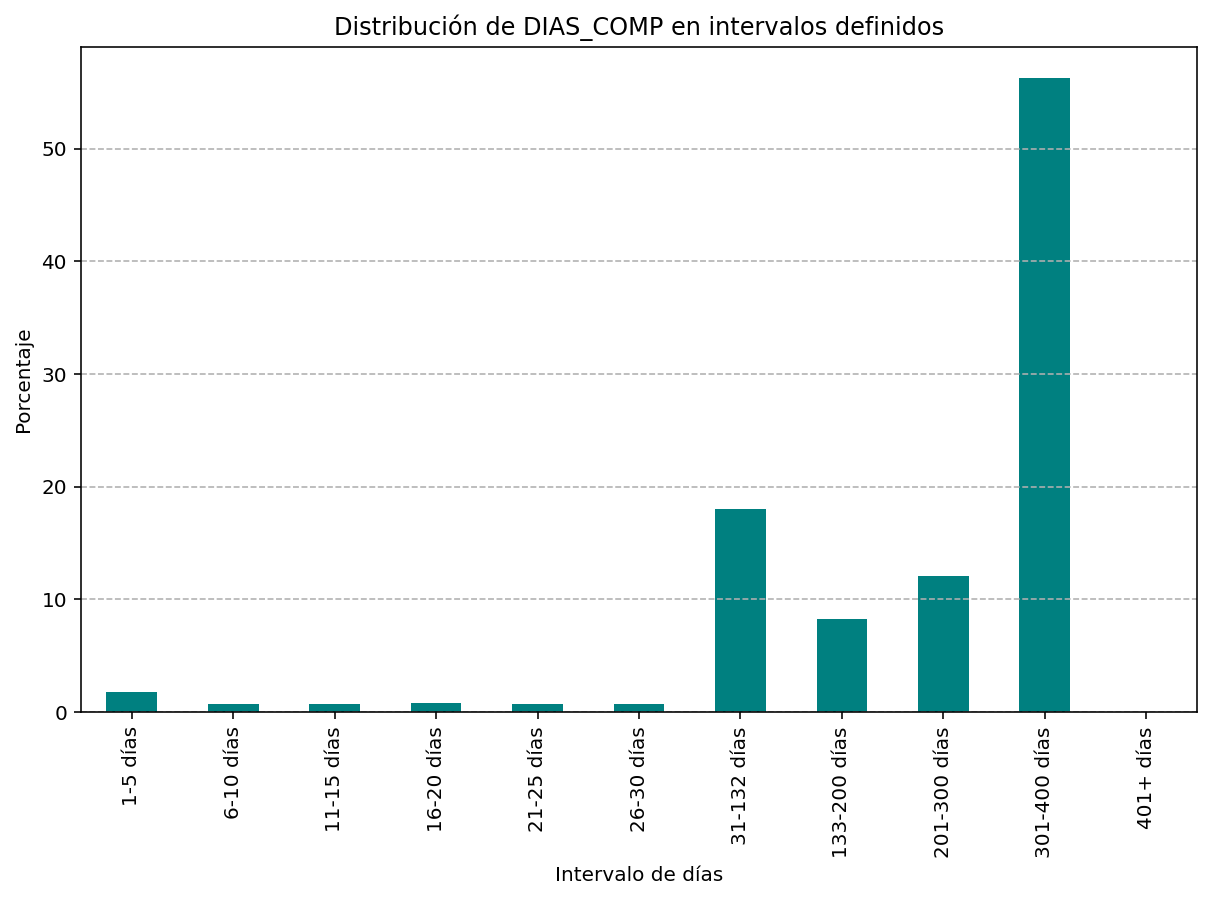

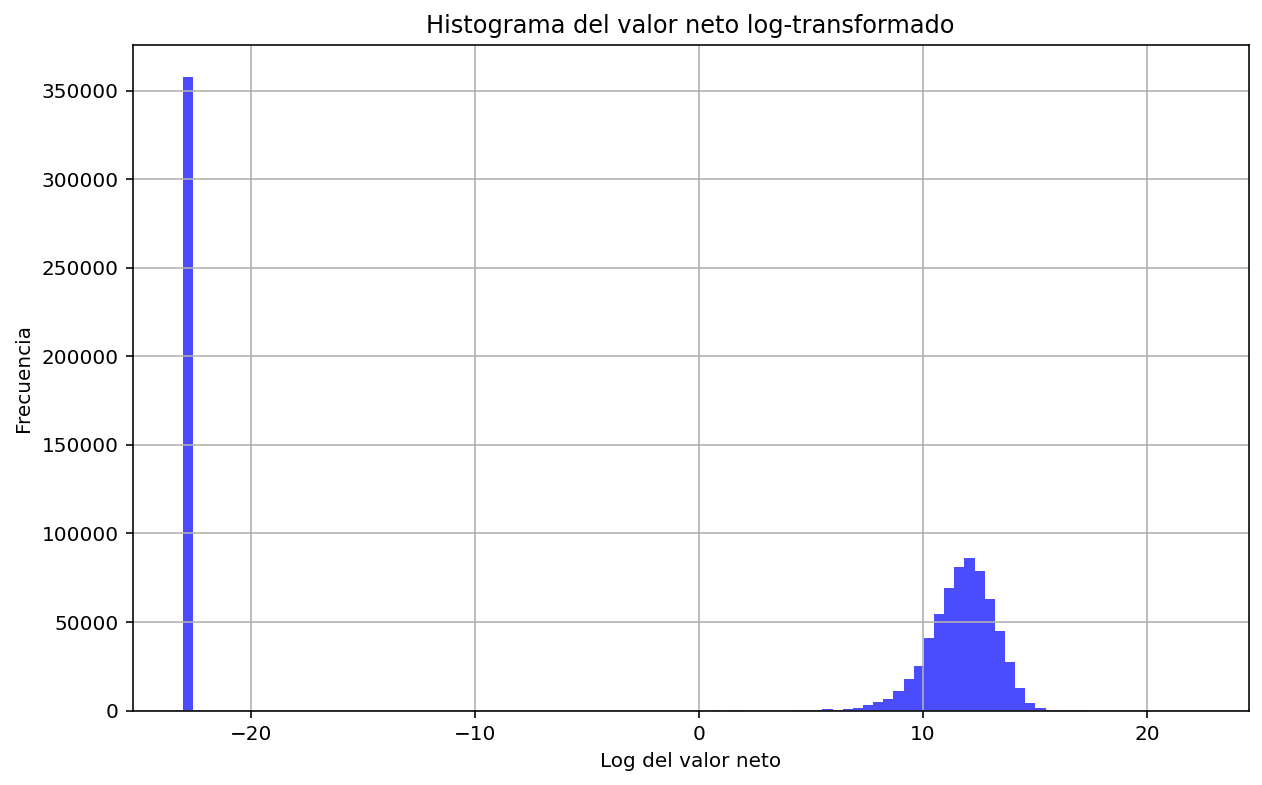

<ipython-input-129-14f163d7b29e>:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-129-14f163d7b29e>:127: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-129-14f163d7b29e>:131: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12

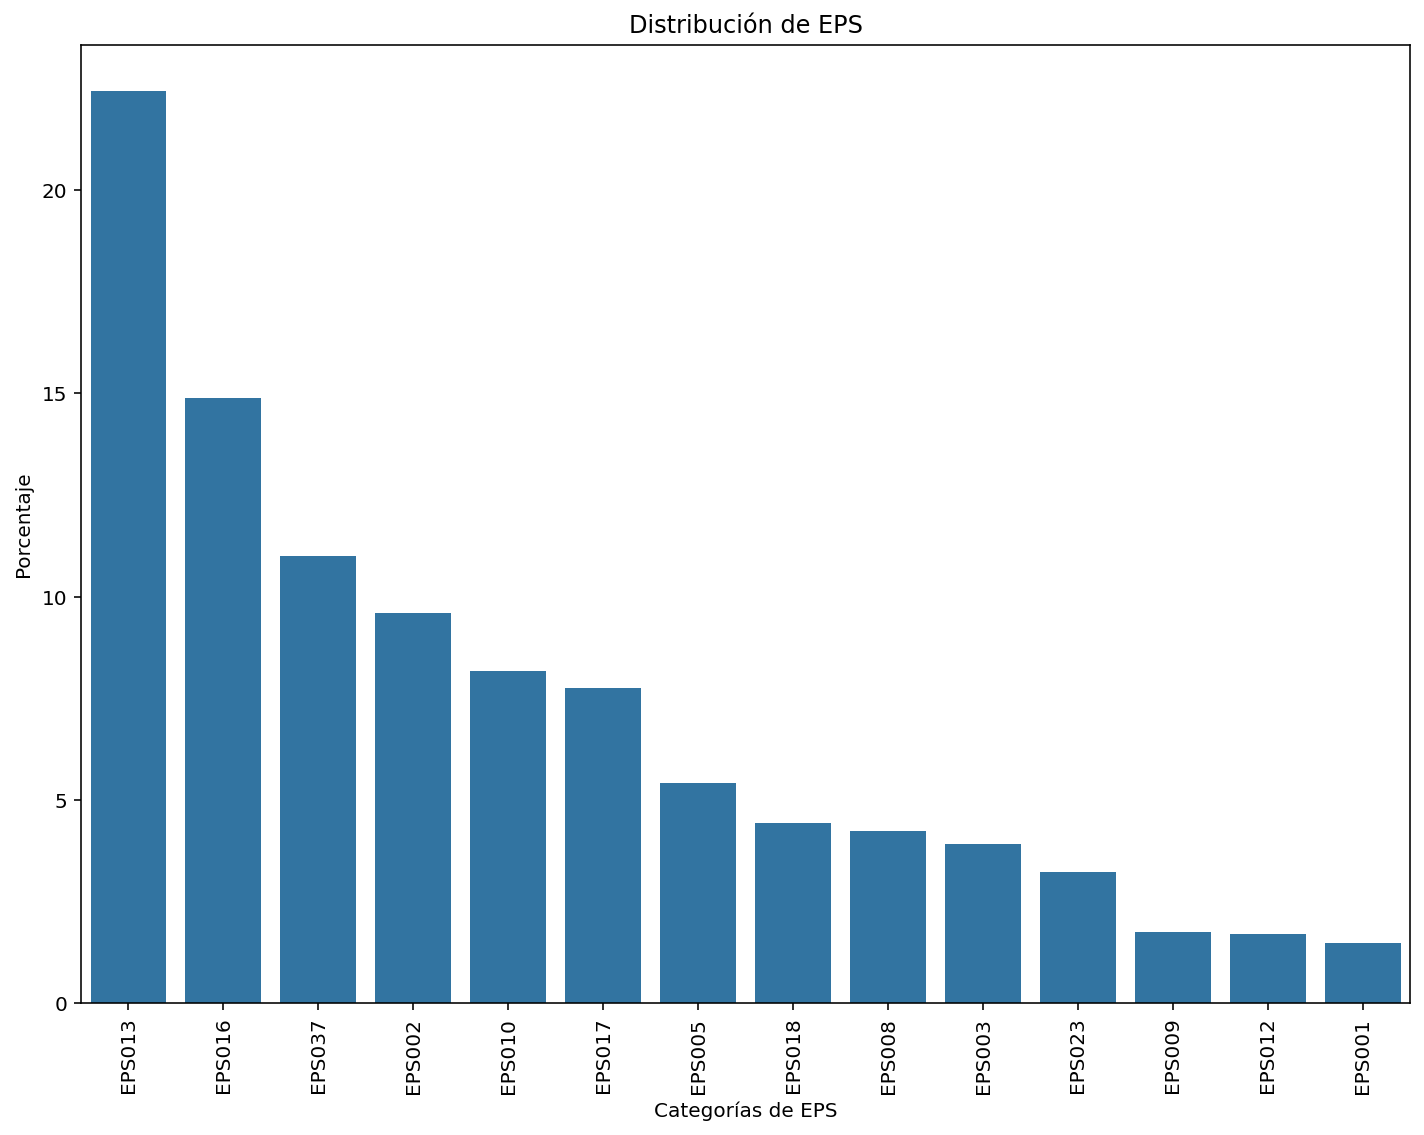

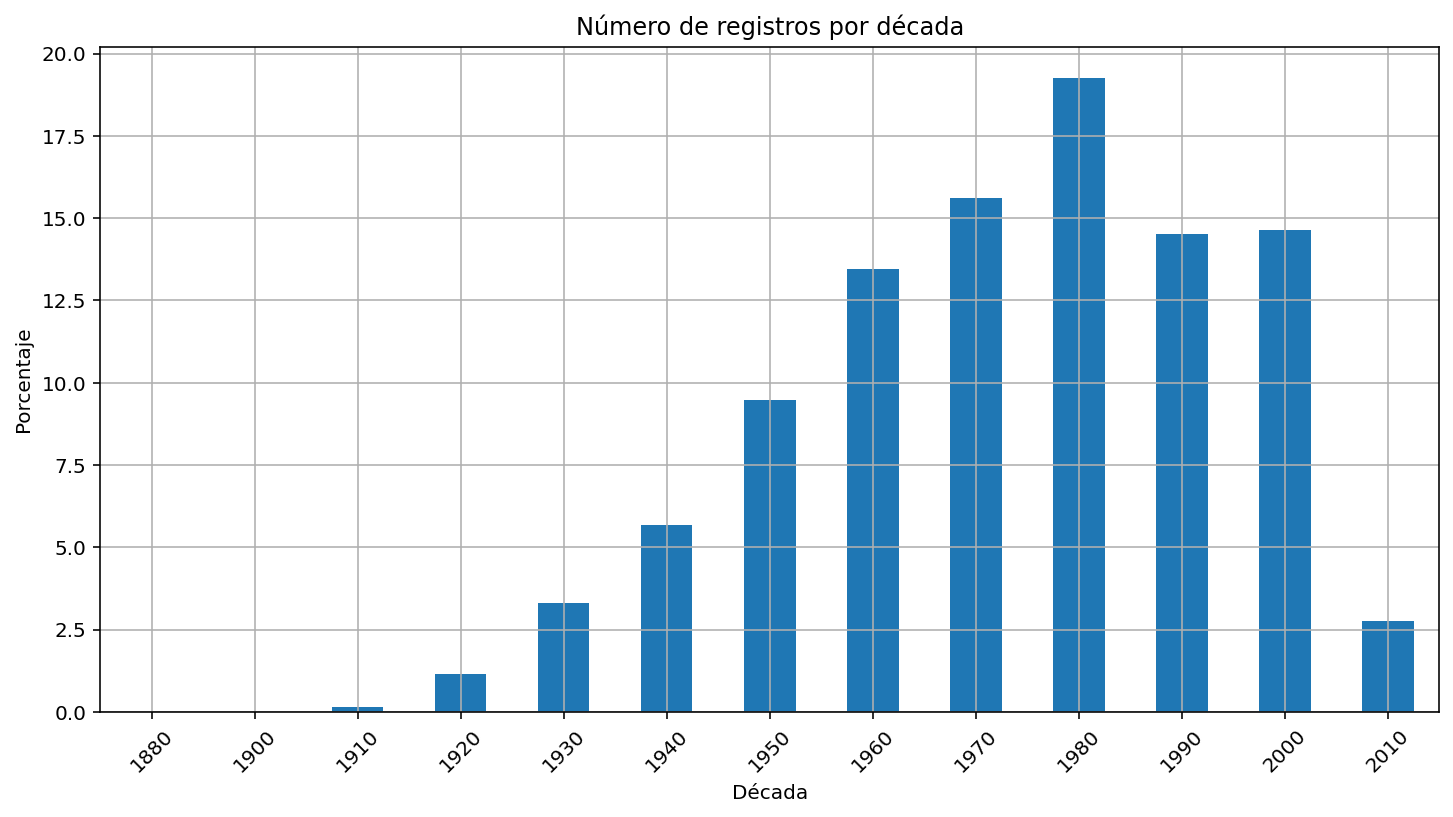

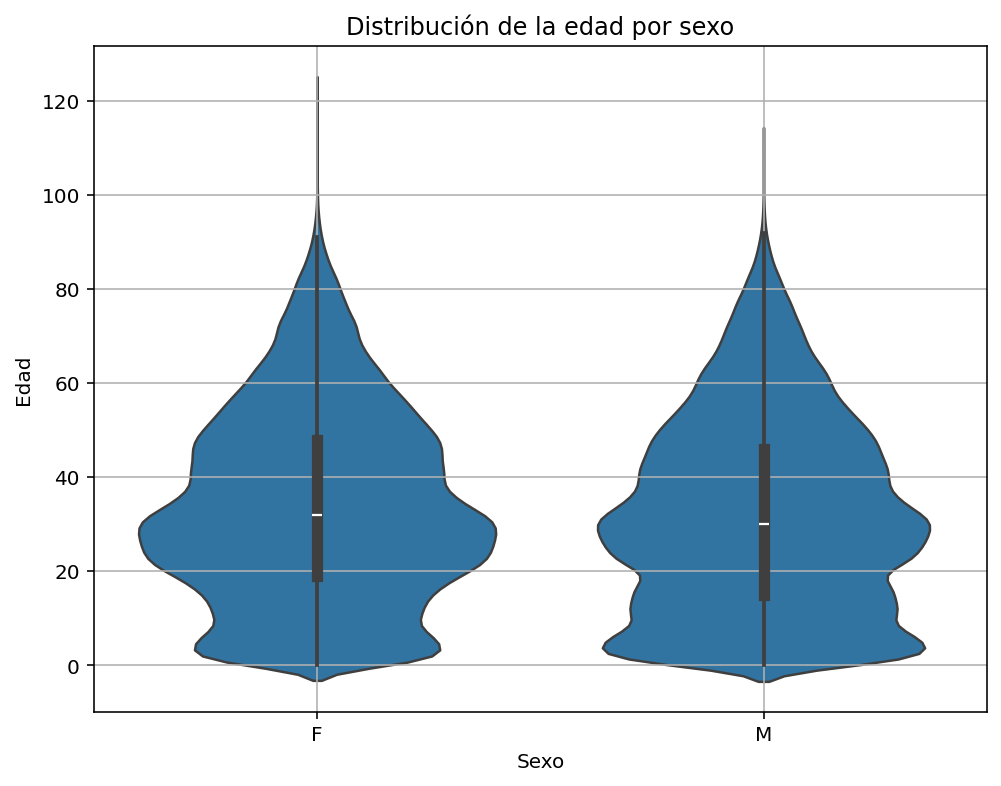

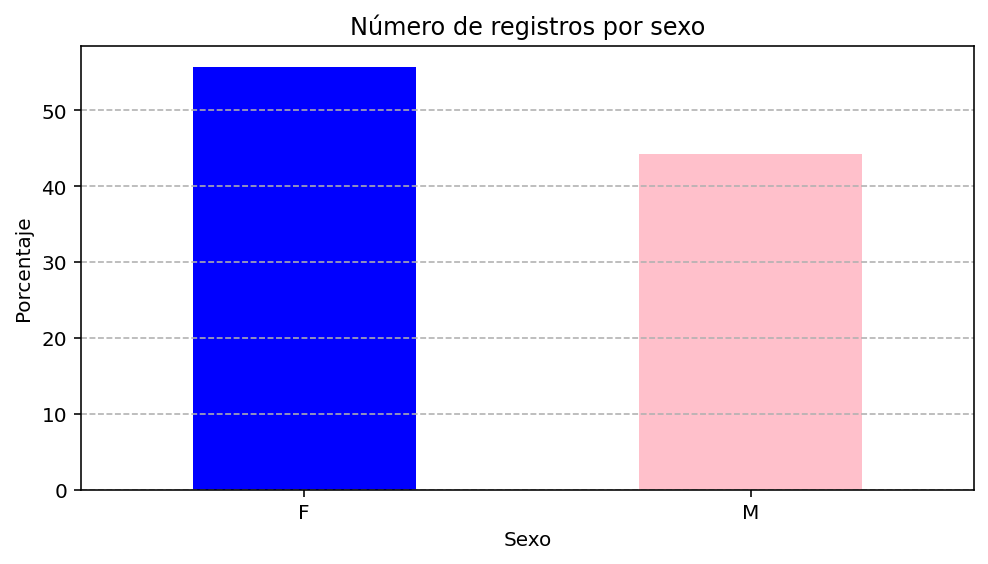

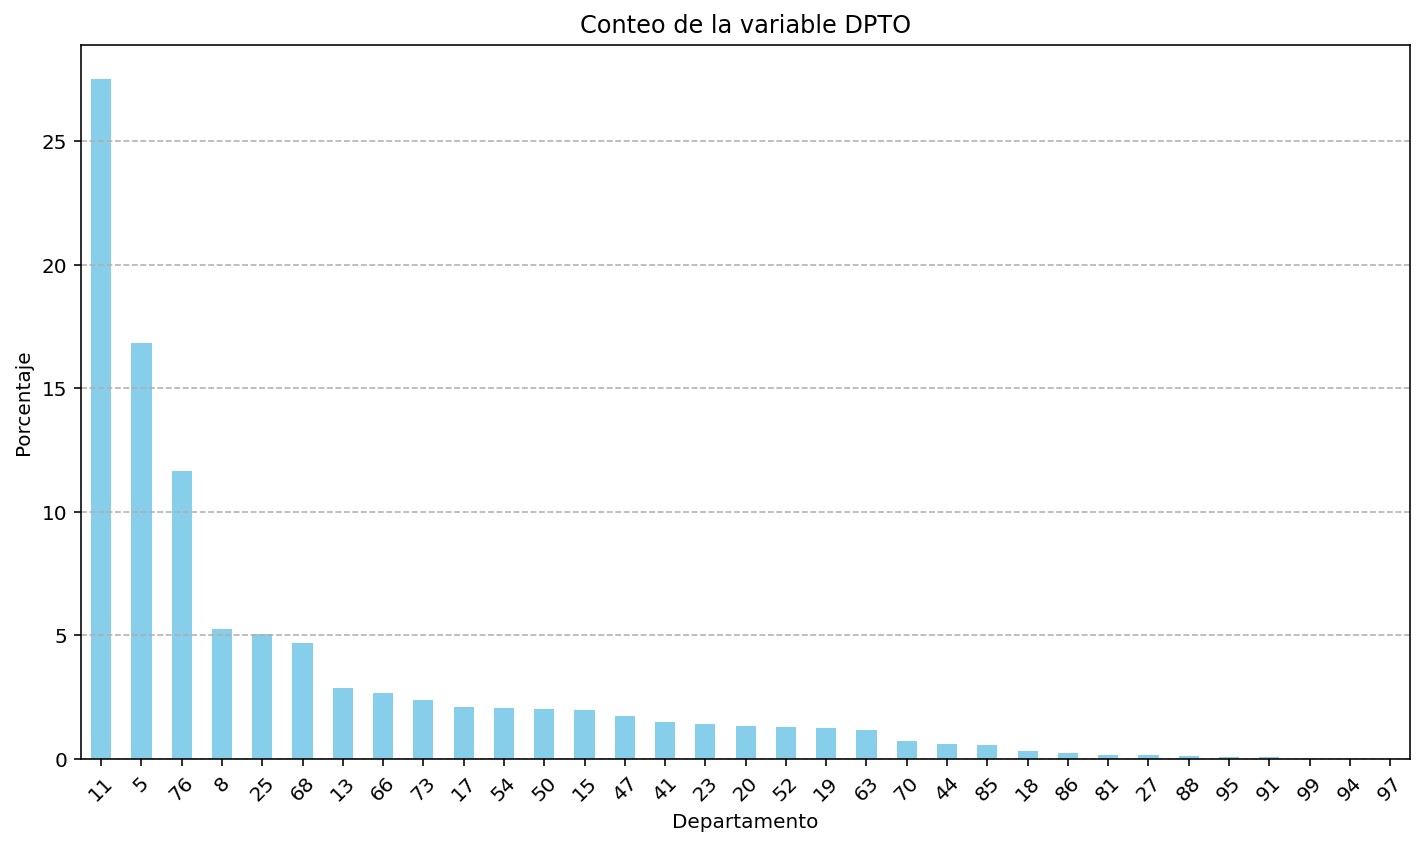

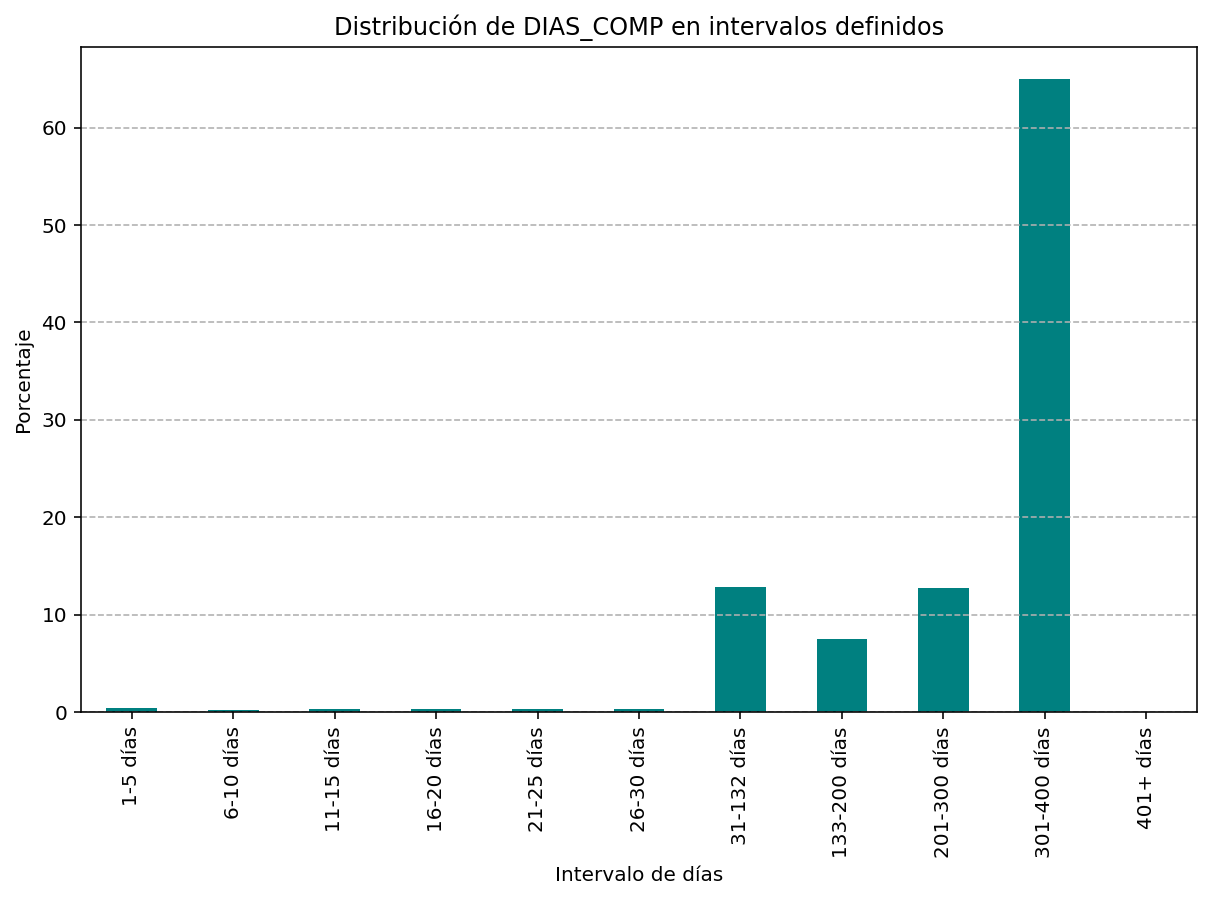

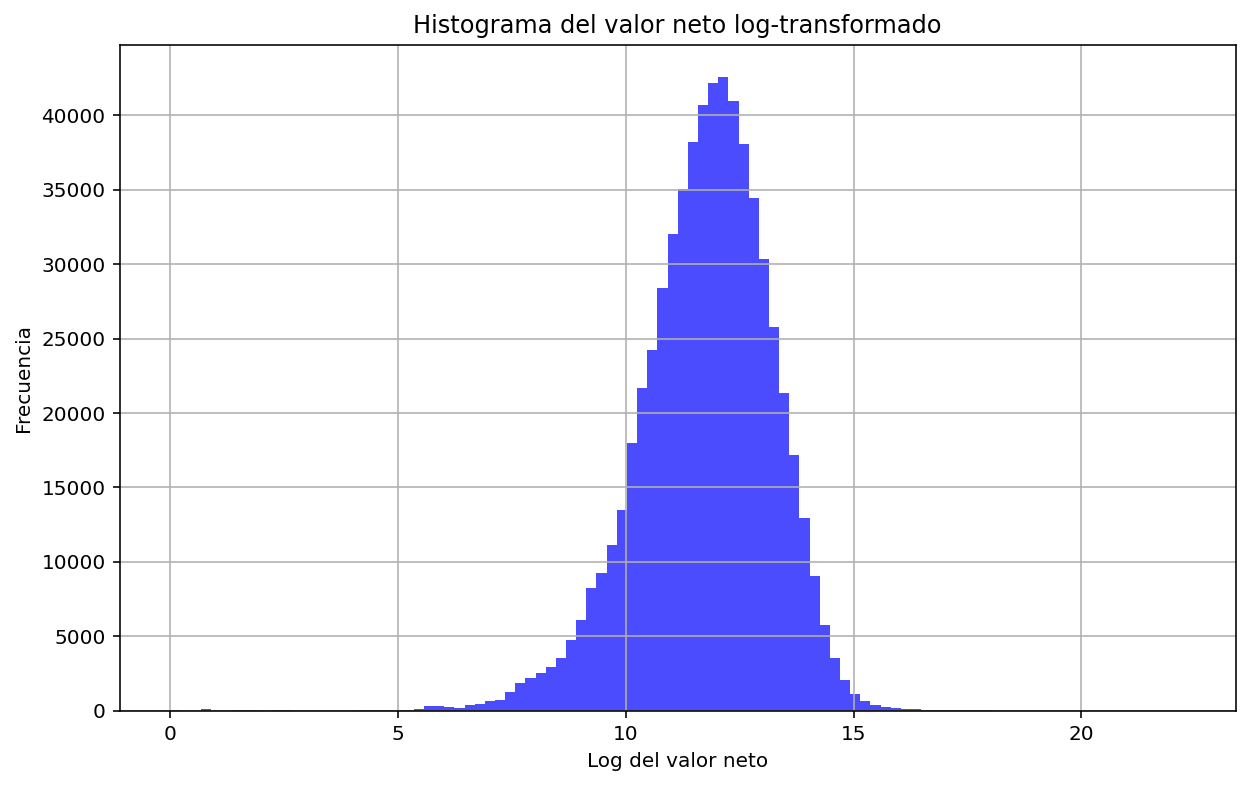

ERROR:__main__:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/usr/local/lib/python3.10/dist-packages/dash/dash.py", line 1373, in dispatch
    ctx.run(
  File "/usr/local/lib/python3.10/dist-packages/dash/_callback.py", line 465, in add_context
    output_value = _invoke_callback(func, *func_args, **func_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/dash/_callback.py", line 4

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn
import plotly.express as px
import geopandas as gpd

# Extender panel para usar Matplotlib y Plotly
pn.extension('plotly')

# Cargar el archivo GeoJSON
gdf = gpd.read_file("/content/colombia.geo.json")

# Agrupar los datos por departamento y calcular la media
costos_por_departamento = data.groupby('DPTO')['Valor_Neto'].mean().reset_index()
costos_por_departamento_sin_gasto = data[data['Valor_Neto'] == 0].groupby('DPTO')['Valor_Neto'].mean().reset_index()
costos_por_departamento_con_gasto = data[data['Valor_Neto'] > 0].groupby('DPTO')['Valor_Neto'].mean().reset_index()
data_gasto = data[data['Valor_Neto'] > 0]
data_sin_gasto = data[data['Valor_Neto'] ==0]

# Asegurarse de que las columnas DPTO sean del mismo tipo
gdf['DPTO'] = gdf['DPTO'].astype(int)
costos_por_departamento['DPTO'] = costos_por_departamento['DPTO'].astype(int)
costos_por_departamento_sin_gasto['DPTO'] = costos_por_departamento_sin_gasto['DPTO'].astype(int)
costos_por_departamento_con_gasto['DPTO'] = costos_por_departamento_con_gasto['DPTO'].astype(int)


# Unir el GeoDataFrame con el DataFrame de datos
gdf_ini = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento, on="DPTO")

# Filtrar los datos basado en el filtro seleccionado
def filtrar_datos(filtro):
    if filtro == "Con Gasto":
        filtered_data = data_gasto
        filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento_con_gasto, on="DPTO")
    elif filtro == "Sin Gasto":
        filtered_data = data_sin_gasto
        filtered_gdf = gdf[['DPTO', 'geometry', 'NOMBRE_DPT']].merge(costos_por_departamento_sin_gasto, on="DPTO")
    else:
        filtered_data = data
        filtered_gdf = gdf_ini
    return filtered_data, filtered_gdf

# Función para crear la figura del mapa
def create_map_figure(filtered_gdf):
    fig = px.choropleth(
        filtered_gdf,
        geojson=filtered_gdf.set_geometry('geometry').__geo_interface__,
        locations=filtered_gdf['DPTO'],
        color="Valor_Neto",
        projection="mercator",
        hover_name="NOMBRE_DPT"
    ).update_geos(
        fitbounds="locations",
        visible=False
    ).update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )
    return fig

# Función para el gráfico de conteo por EPS
def plot_eps_count(filtered_data):
    plt.figure(figsize=(10, 8))
    count_data = filtered_data['EPS'].value_counts(normalize=True) * 100
    sns.barplot(x=count_data.index, y=count_data.values)
    plt.title('Distribución de EPS')
    plt.xlabel('Categorías de EPS')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=90)
    plt.tight_layout()
    return pn.pane.Matplotlib(plt.gcf(), tight=True)

# Función para el gráfico de registros por década
def plot_decade_count(filtered_data):
    filtered_data['Decade'] = (filtered_data['FECHA_NACI'].dt.year // 10) * 10
    decade_counts = filtered_data['Decade'].value_counts(normalize=True).sort_index() * 100

    plt.figure(figsize=(12, 6))
    decade_counts.plot(kind='bar')
    plt.title('Número de registros por década')
    plt.xlabel('Década')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45)
    plt.grid(True)
    return pn.pane.Matplotlib(plt.gcf(), tight=True)

# Función para el gráfico de distribución de edad por sexo
def plot_age_sex_distribution(filtered_data):
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='SEXO', y='Edad', data=filtered_data)
    plt.title('Distribución de la edad por sexo')
    plt.xlabel('Sexo')
    plt.ylabel('Edad')
    plt.grid(True)
    return pn.pane.Matplotlib(plt.gcf(), tight=True)

# Función para el gráfico de registros por sexo
def plot_sex_count(filtered_data):
    sexo_counts = filtered_data['SEXO'].value_counts(normalize=True) * 100

    plt.figure(figsize=(8, 4))
    sexo_counts.plot(kind='bar', color=['blue', 'pink'])
    plt.title('Número de registros por sexo')
    plt.xlabel('Sexo')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--')
    return pn.pane.Matplotlib(plt.gcf(), tight=True)

# Función para el gráfico de conteo de DPTO
def plot_dpto_count(filtered_data):
    dpto_counts = filtered_data['DPTO'].value_counts(normalize=True) * 100

    plt.figure(figsize=(10, 6))
    dpto_counts.plot(kind='bar', color='skyblue')
    plt.title('Conteo de la variable DPTO')
    plt.xlabel('Departamento')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    return pn.pane.Matplotlib(plt.gcf(), tight=True)

# Función para el gráfico de distribución de DIAS_COMP
def plot_dias_comp_distribution(filtered_data):
    filtered_data['DIAS_COMP'] = pd.to_numeric(filtered_data['DIAS_COMP'], errors='coerce')
    bins = [0, 5, 10, 15, 20, 25, 30, 132, 200, 300, 400, filtered_data['DIAS_COMP'].max() + 1]
    labels = ['1-5 días', '6-10 días', '11-15 días', '16-20 días', '21-25 días', '26-30 días', '31-132 días',
              '133-200 días', '201-300 días', '301-400 días', '401+ días']
    filtered_data['DIAS_COMP_Binned'] = pd.cut(filtered_data['DIAS_COMP'], bins=bins, labels=labels, right=False)
    binned_counts = filtered_data['DIAS_COMP_Binned'].value_counts(normalize=True).sort_index() * 100

    plt.figure(figsize=(10, 6))
    binned_counts.plot(kind='bar', color='teal')
    plt.title('Distribución de DIAS_COMP en intervalos definidos')
    plt.xlabel('Intervalo de días')
    plt.ylabel('Porcentaje')
    plt.grid(axis='y', linestyle='--')
    return pn.pane.Matplotlib(plt.gcf(), tight=True)

# Función para el gráfico de histograma de Valor_Neto_Log
def plot_valor_neto_log(filtered_data):
    filtered_data['Valor_Neto_Log'] = np.log(filtered_data['Valor_Neto'] + 1e-10)
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_data['Valor_Neto_Log'], bins=100, color='blue', alpha=0.7)
    plt.title('Histograma del valor neto log-transformado')
    plt.xlabel('Log del valor neto')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    return pn.pane.Matplotlib(plt.gcf(), tight=True)

# Crear los botones para seleccionar el filtro
filtro_buttons = pn.widgets.RadioButtonGroup(
    name='Filtro de Datos',
    options=['Toda la Data', 'Con Gasto', 'Sin Gasto'],
    button_type='success'
)

# Panel interactivo
@pn.depends(filtro_buttons.param.value)
def interactive_plot(filtro):
    filtered_data, filtered_gdf = filtrar_datos(filtro)

    # Crear el mapa
    map_fig = create_map_figure(filtered_gdf)
    map_plot = pn.pane.Plotly(map_fig, config={'displayModeBar': False})

    # Crear los gráficos y organizarlos en una columna
    eps_count_plot = plot_eps_count(filtered_data)
    decade_count_plot = plot_decade_count(filtered_data)
    age_sex_distribution_plot = plot_age_sex_distribution(filtered_data)
    sex_count_plot = plot_sex_count(filtered_data)
    dpto_count_plot = plot_dpto_count(filtered_data)
    dias_comp_distribution_plot = plot_dias_comp_distribution(filtered_data)
    valor_neto_log_plot = plot_valor_neto_log(filtered_data)

    # Crear el layout con todos los gráficos
    layout = pn.Column(
        map_plot,
        eps_count_plot,
        decade_count_plot,
        age_sex_distribution_plot,
        sex_count_plot,
        dpto_count_plot,
        dias_comp_distribution_plot,
        valor_neto_log_plot
    )

    return layout

# Layout del Panel
dashboard = pn.Column(
    "# Dashboard de Gráficos",
    filtro_buttons,
    interactive_plot
)

# Servir la aplicación
dashboard.servable()

In [122]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import pandas as pd
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

# Definir Texto Intro
intro_text = """
Bienvenido al Dashboard EDA y Modelos

Este es un dashboard interactivo creado con Plotly Dash. Aquí puedes explorar datos y ejecutar modelos.

Selecciona una base de datos y explora el análisis exploratorio de datos (EDA) o ejecuta un modelo.
"""

# Crear la aplicación Dash
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP],
                meta_tags=[{"name": "viewport", "content": "width=device-width, initial-scale=1.0"}],  # Etiquetas meta para responsividad
                suppress_callback_exceptions=True,  # Suprimir excepciones de callback
                title='Privacidad Diferencial de Datos',  # Título de la página
                update_title='Cargando...',  # Título temporal durante la actualización de callbacks
                serve_locally=True,  # Servir archivos locales
)

# Definir el layout de la aplicación
app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    dbc.NavbarSimple(
        children=[
            dbc.NavItem(dbc.NavLink("Introducción", href="/")),
            dbc.NavItem(dbc.NavLink("Análisis Descriptivo Exploratorio", href="/eda")),
            dbc.NavItem(dbc.NavLink("Modelos", href="/modelos")),
            dbc.NavItem(dbc.NavLink("Conclusiones", href="/conclusiones")),
        ],
        brand="Privacidad Diferencial de Datos",
        color="primary",
        dark=True,
    ),
    html.Div(id='page-content')
])

# Componente común del pie de página
footer = html.Div([
    html.Img(src='https://upload.wikimedia.org/wikipedia/commons/c/c9/Universidad_de_los_Andes_%28logo%29.png', style={'display': 'block', 'margin': 'auto', 'width': '100px'}),
    html.P(['Maestría en Inteligencia Análitica para la',
        html.Br(),
        'Toma de Decisiones',
        html.Br(),
        'Autores:'
    ], style={'textAlign': 'center', 'marginTop': 10}),
    html.Ul([
        html.Li('Luisa De La Hortúa'),
        html.Li('David Romero'),
        html.Li('David Moreno'),
        html.Li('Allan Ramírez')
    ], style={'textAlign': 'center', 'listStylePosition': 'inside'})
], style={'marginTop': 50})

# Página de Introducción
intro_layout = html.Div([
    html.H1('Introducción'),
    html.Hr(),
    html.P(intro_text),
    # Ejemplo de tabla
    dash_table.DataTable(data=data.head(5).to_dict('records'), page_size=6),
    html.Br(),
    html.P('Continuación de la intro.'),
    footer  # Añadir el pie de página
])

# Página de Análisis Descriptivo Exploratorio
eda_layout = html.Div([
    html.H1('Análisis Descriptivo Exploratorio'),
    html.Hr(),
    html.H2('Gráficos Interactivos'),
    html.Iframe(src="http://localhost:5006/dashboard_panel", width="100%", height="800px"),
    footer  # Añadir el pie de página
])

# Página de Modelos
modelos_layout = html.Div([
    html.H1('Modelos'),
    html.Hr(),
    html.P('Esta es la página de modelos.'),
    footer  # Añadir el pie de página
])

# Página de Conclusiones
conclusiones_layout = html.Div([
    html.H1('Conclusiones'),
    html.Hr(),
    html.P('Esta es la página de conclusiones.'),
    footer  # Añadir el pie de página
])

# Callback para actualizar el contenido de la página
@app.callback(Output('page-content', 'children'),
              [Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/eda':
        return eda_layout
    elif pathname == '/modelos':
        return modelos_layout
    elif pathname == '/conclusiones':
        return conclusiones_layout
    else:
        return intro_layout

# Ejecutar la aplicación
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>